## ** A New Non-intrusive Load Monitoring Method for Residential Appliances **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * NILM model results cannot be used directly, so they must be post-processed.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.

In [1]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

from benchmark.metrics import recall_precision_accuracy_f1, relative_error_total_energy, mean_absolute_error

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)

/home/kgbmanse/anaconda3/envs/nilm/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


#### Configuration

In [2]:
###############################################################
# Common
###############################################################

# 6s
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = 'data/enertalk.h5'

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

HOME_ID = 1
appliances = ['washing machine', 'rice cooker', 'microwave']

## (1) Result Processing

- Description
  The find_peaks function in the Python scipy package was used to identify when the appliance was activated. The proper input parameters were set to detect peaks that indicated appliance operation.
  * For example, washing machines were determined to be operating if they were consuming at least 50% of their maximum energy consumption, which can be acquired during training or through other methods (height). Setting this limit filtered out predictions based on small amounts of energy consumed that would make the model less accurate. Peaks also had to occur for at least 10 minutes (width)
  * For the rice cooker, a minimum interval between activations was set to 20 minutes (distance), which was usually because the appliance was not used continuously at short intervals of time. Since the rice cooker continues to use power to keep warm even after cooking, it is not recommended to specify the width parameter corresponding to the peak duration
  * The parameters used for rice cooker were adopted to detect microwave activation, which is because both as cooking appliances were expected to show similar usage patterns  

********************
[DRF-washing machine]
********************


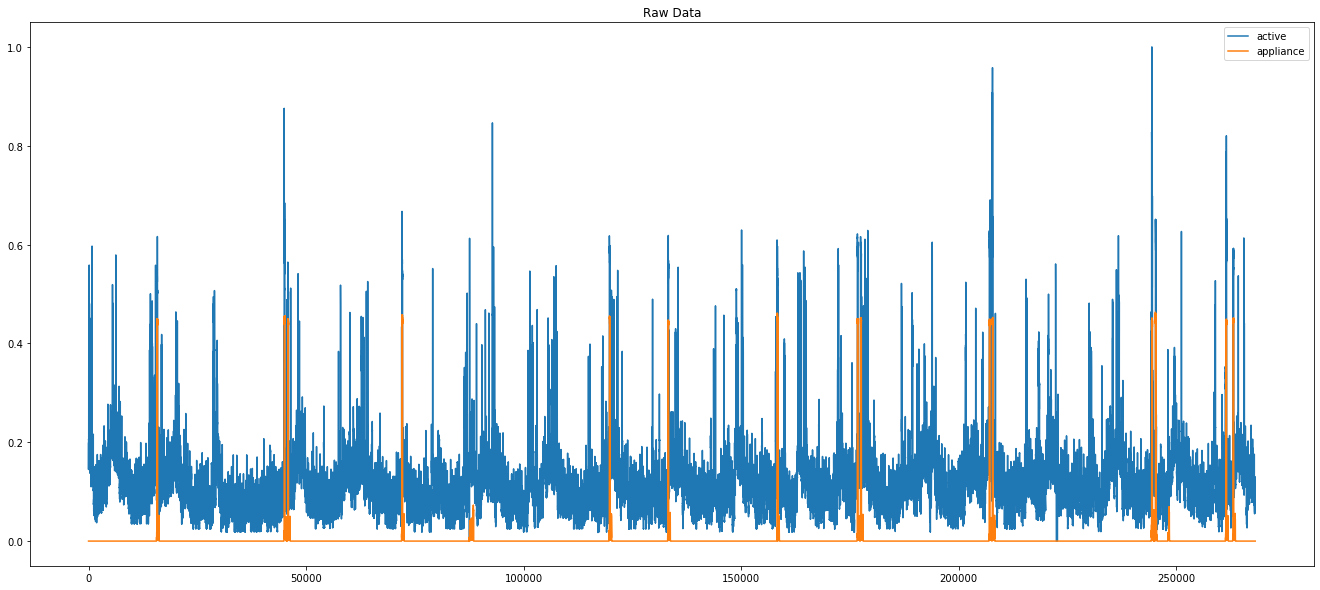

feature selection is done..
model fit is done..
min     0.864034
diff    0.033191
a9      0.033001
q0      0.009177
std     0.006994
max     0.006566
a0      0.005540
q1      0.004314
a8      0.004240
f5      0.002873
q2      0.002513
a1      0.001999
a6      0.001949
f1      0.001912
a7      0.001886
a2      0.001771
f7      0.001757
f9      0.001702
f3      0.001576
a5      0.001549
f6      0.001536
a3      0.001517
f2      0.001469
mean    0.001462
f8      0.001454
f4      0.001435
f0      0.001399
a4      0.001185
dtype: float64


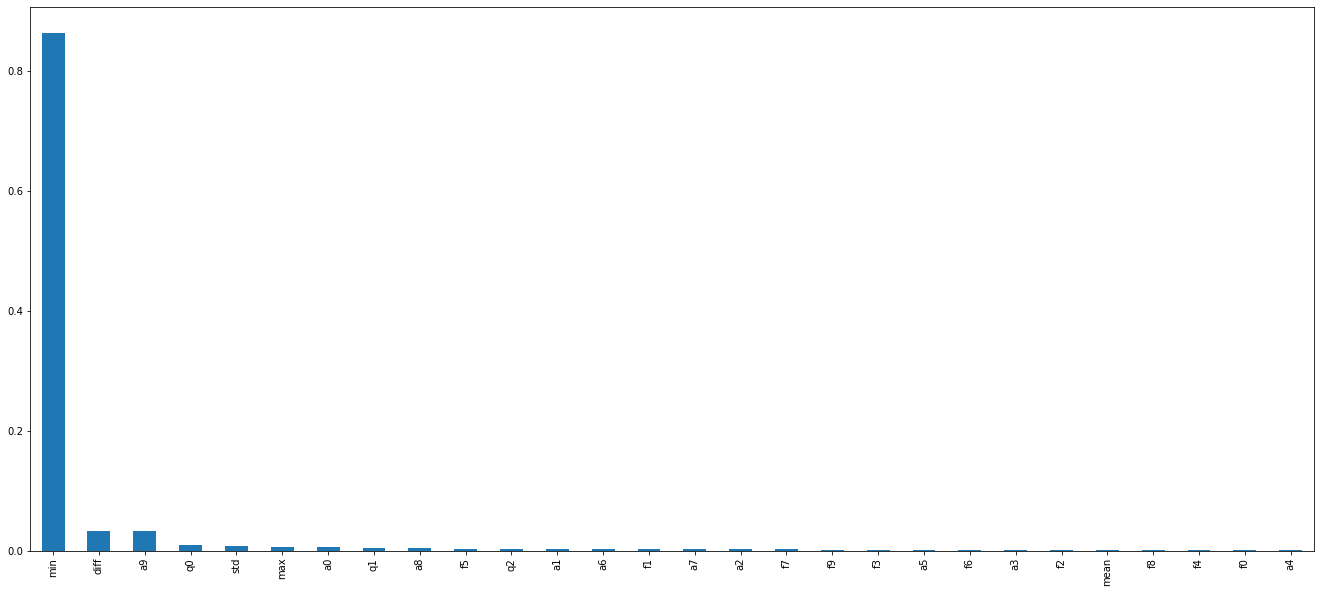

train on chunk is done..
elapsed time (secs) = 2111.422320127487
********************
[DRF-rice cooker]
********************


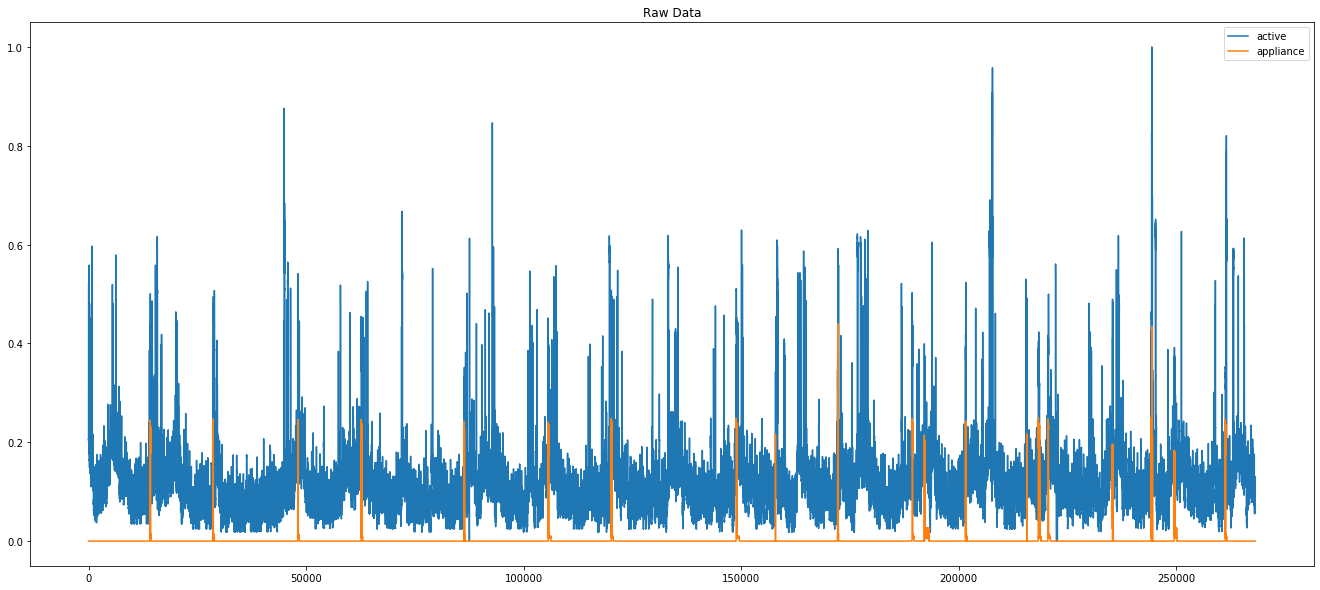

feature selection is done..
model fit is done..
a9      0.459232
min     0.092730
diff    0.079875
a1      0.058459
std     0.054418
max     0.048154
a8      0.039631
q2      0.018005
q0      0.017612
a0      0.014620
q1      0.014007
f5      0.010172
a7      0.007941
f9      0.007835
f1      0.007026
a2      0.006786
f6      0.006232
f4      0.006211
a5      0.005980
a6      0.005816
f3      0.005450
f7      0.005413
f8      0.004899
a3      0.004891
f2      0.004874
mean    0.004778
f0      0.004634
a4      0.004320
dtype: float64


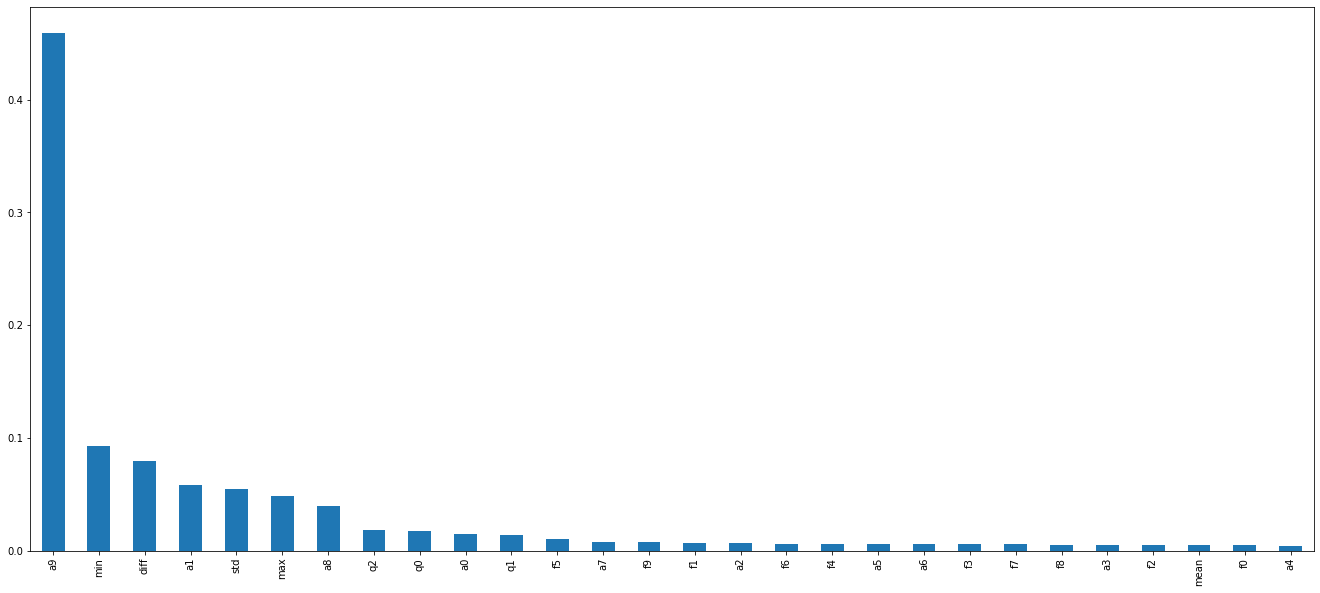

train on chunk is done..
elapsed time (secs) = 1961.0505657196045
********************
[DRF-microwave]
********************


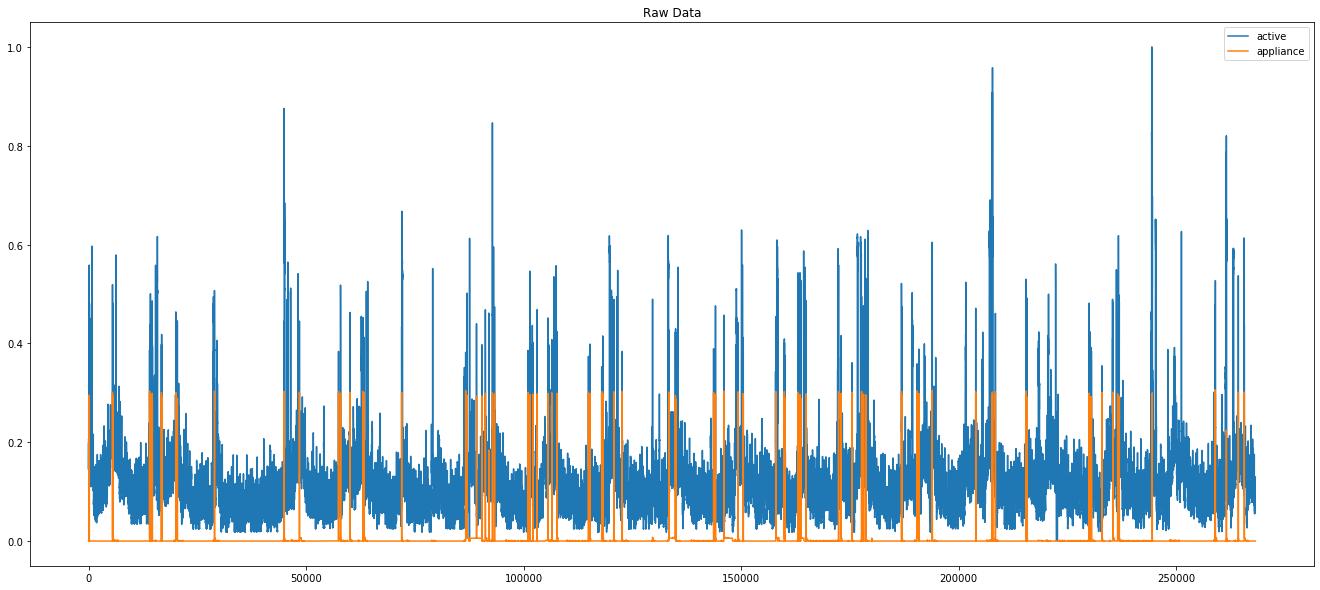

feature selection is done..
model fit is done..
diff    0.334153
a9      0.141353
f6      0.074729
f4      0.068392
a8      0.045220
q0      0.043345
max     0.039862
min     0.034828
f5      0.033596
std     0.027808
a7      0.015307
a0      0.014609
q2      0.012227
a1      0.011151
q1      0.009593
a5      0.009525
f7      0.008722
a2      0.008554
f1      0.008496
f3      0.008272
a3      0.007797
f9      0.007664
f2      0.007207
a4      0.007090
f8      0.006228
a6      0.005671
f0      0.004751
mean    0.003849
dtype: float64


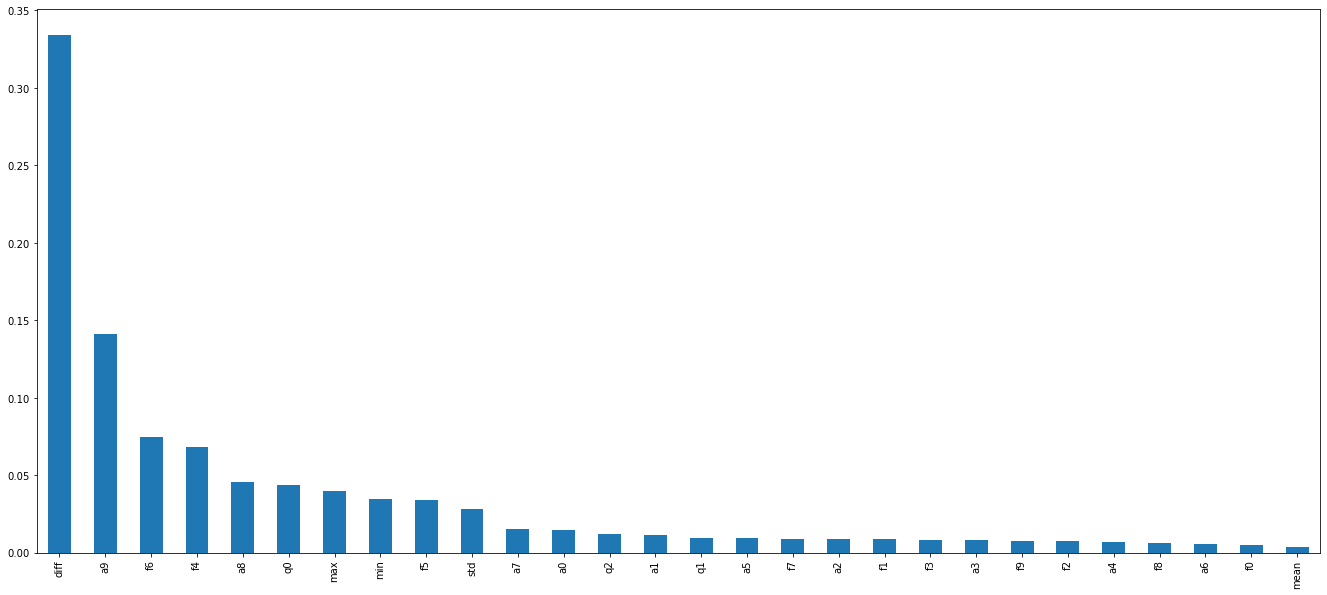

train on chunk is done..
elapsed time (secs) = 1914.5947635173798


In [3]:
dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

models = {}

for aname in appliances:
    
    try:
    
        train_meter = train_elec.submeters()[aname]
        
        mname = 'DRF-' + aname

        models[mname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
        
        print("*"*20)
        print("[" + mname + "]") 
        print("*" *20)

        start = time.time()
        models[mname].train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        end = time.time()            
        print("elapsed time (secs) = " + str(end-start))
        
    except Exception as e:
        print('train error', e)   

In [16]:
def count_num_of_activations(total, predicted, ground_truth, appliance_max):
    
    #least_amount = appliance_max / 10
    least_amount = appliance_max / 2
    
    legends = []
    
    t = total.power_series_all_data()    
    #plt.plot(t, linewidth=2)
    #legends.append('total')
    
    if ground_truth is not None:
        gt = ground_truth.power_series_all_data()        
        plt.plot(gt, linewidth=2)
        legends.append('appliance (actual)')
    
    pred = predicted.power_series_all_data()
    plt.plot(pred, linewidth=2)
    legends.append('appliance (predicted)')    
    
    print(type(pred))
    
    # washing machine : height=50%, width=100, prominence = 1
    # rice cooker : height=50%, distance=200, prominence = 1
    # microwave : height=50%, width=2, distance=200, prominence = 1 
    peaks, properties = find_peaks(pred, height=least_amount, distance=200, prominence=1)  

    print(f'activations : {peaks}')

    print(np.diff(peaks))
    
    plt.plot(pred.index[peaks], pred[peaks], "o")
    plt.legend(legends)        
    plt.show()    
    
    return len(peaks)

In [17]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[HOME_ID].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[HOME_ID].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
    return count_num_of_activations(test_mains, predicted, ground_truth, model.meter_mmax)

********************
[DRF-washing machine]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.5832869080779944
============ Precision: 0.620260663507109
============ Accuracy: 0.9035416666666667
============ F1 Score: 0.6012058570198106
============ Relative error in total energy: 0.06027240355288029
============ Mean absolute error(in Watts): 11.90536505803489
<class 'pandas.core.series.Series'>
activations : [ 5398  6368  7374 12089]
[ 970 1006 4715]


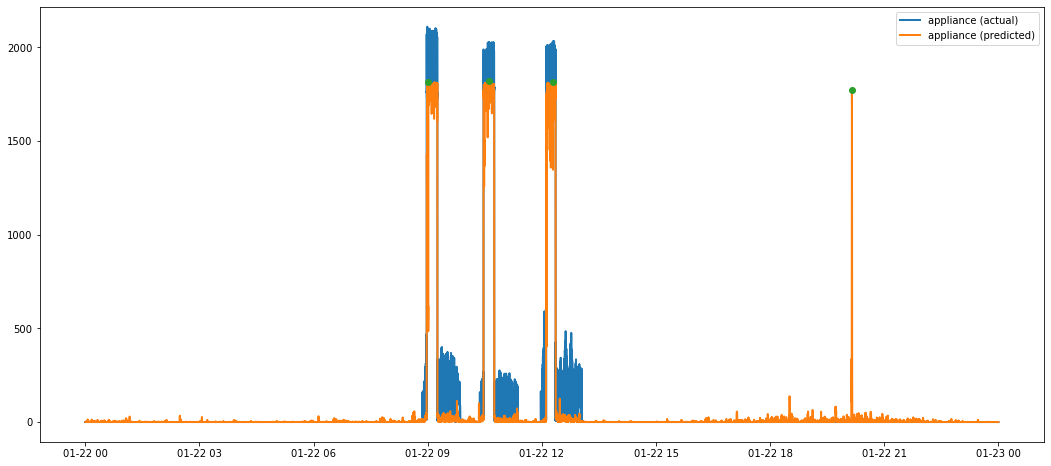

********************
[DRF-rice cooker]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.44699367088607594
============ Precision: 0.6958128078817734
============ Accuracy: 0.9343055555555555
============ F1 Score: 0.5443159922928709
============ Relative error in total energy: 0.16961384967740673
============ Mean absolute error(in Watts): 6.611070800319998
<class 'pandas.core.series.Series'>
activations : [ 5230 11929]
[6699]


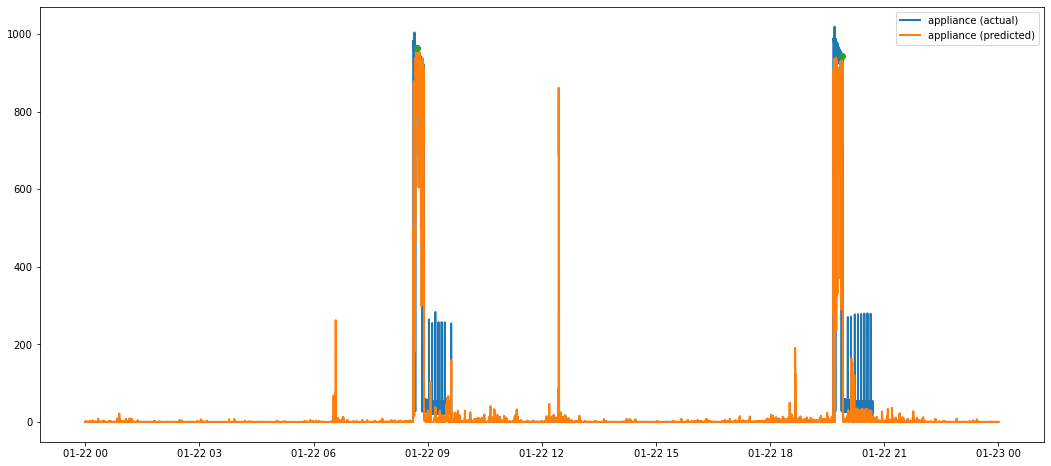

********************
[DRF-microwave]
********************
New sensible chunk: 14400
feature selection is done..
Disaggregation is done..
============ Recall: 0.1190721649484536
============ Precision: 0.4052631578947368
============ Accuracy: 0.8577777777777778
============ F1 Score: 0.18406374501992032
============ Relative error in total energy: 0.09629116462112527
============ Mean absolute error(in Watts): 7.761000561698304
<class 'pandas.core.series.Series'>
activations : [ 5444  5769  7460 11099 11820 12131 12421]
[ 325 1691 3639  721  311  290]


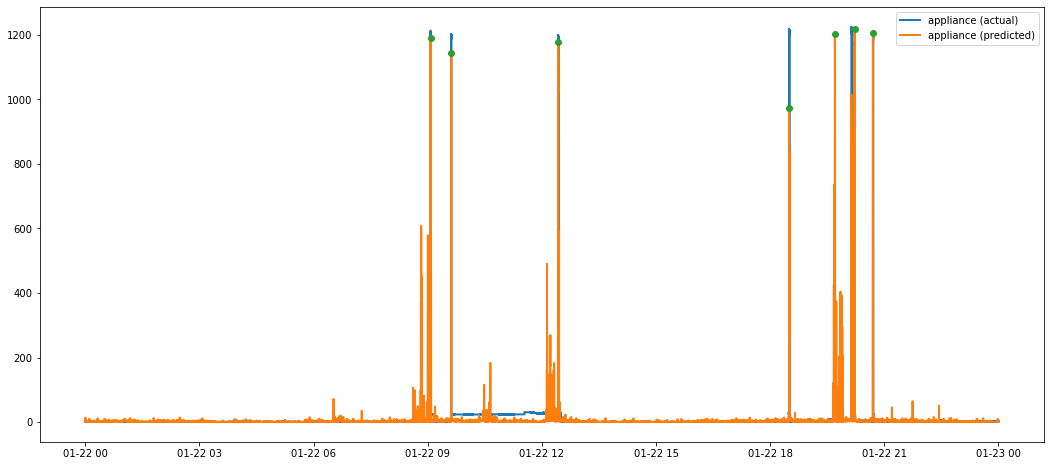

In [18]:
P_S = '2017-01-22 00:00:00'
P_E = '2017-01-23 00:00:00'

rcParams['figure.figsize'] = (18, 8)

for mname, model in models.items():

    try:

        print("*"*20)
        print("[" + mname + "]") 
        print("*" *20)

        num_of_activations = disaggregate(dataset, model, mname[4:], P_S, P_E, True)

    except Exception as e:
        print('train & test error', e)

rcParams['figure.figsize'] = (23, 10)

## (2) Long Sampling Period

- Description
  Most meters currently installed by power companies take readings every 15 minutes. Therefore, it is necessary how the proposed method performs if deployed on meters currently in use.

### Sampling Period : 30 second

********************
[DRF-washing machine]
********************


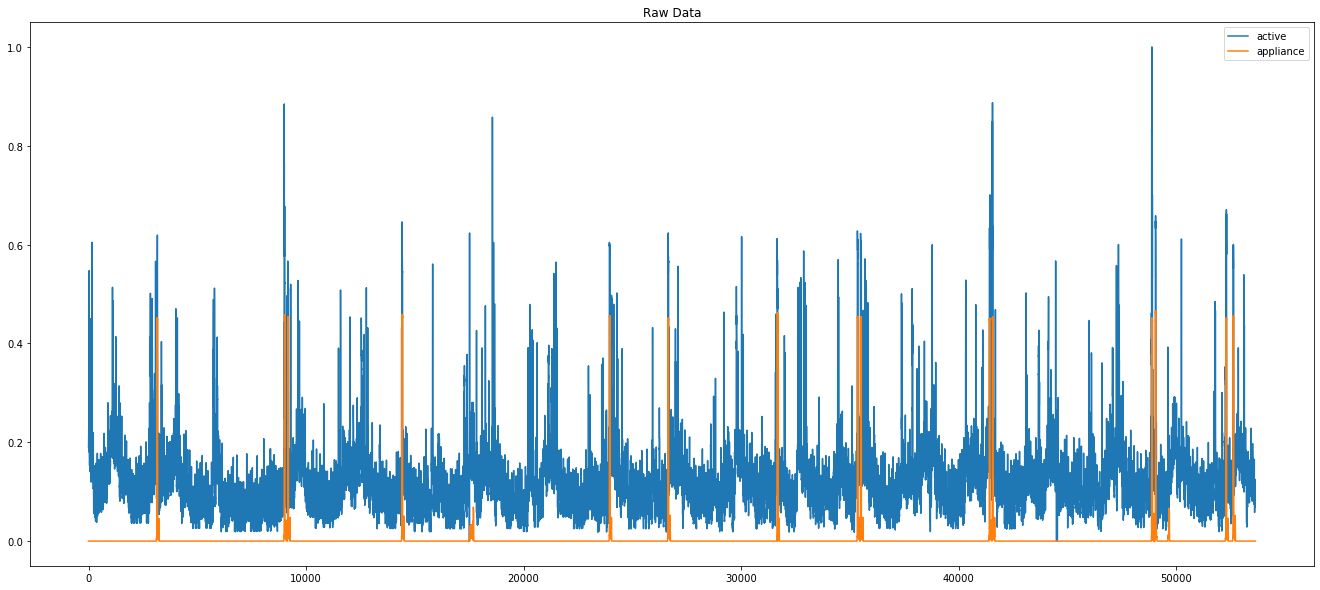

feature selection is done..
model fit is done..
a9      0.837091
q2      0.071327
diff    0.017069
a8      0.010537
min     0.009131
q0      0.006638
max     0.004081
a2      0.003832
f5      0.003800
q1      0.003731
std     0.003569
a6      0.003565
f0      0.003515
mean    0.002939
a0      0.002246
a5      0.001808
f4      0.001747
f8      0.001464
f9      0.001303
a1      0.001279
f6      0.001279
f2      0.001269
a3      0.001268
f1      0.001222
f3      0.001162
a7      0.001107
f7      0.001097
a4      0.000924
dtype: float64


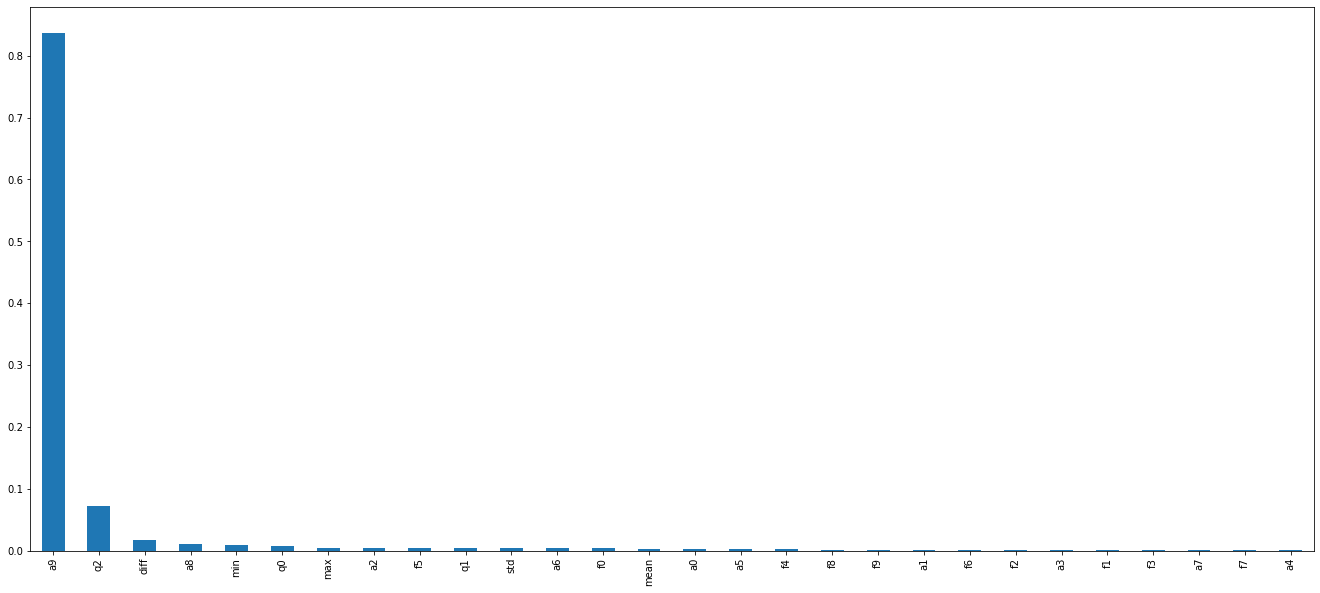

train on chunk is done..
elapsed time (secs) = 346.0916111469269
New sensible chunk: 11921
feature selection is done..
New sensible chunk: 5792
feature selection is done..
New sensible chunk: 11072
feature selection is done..
Disaggregation is done..
============ Recall: 0.3871829105473965
============ Precision: 0.33819241982507287
============ Accuracy: 0.9286806086291948
============ F1 Score: 0.3610333022097728
============ Relative error in total energy: 0.027839333181680342
============ Mean absolute error(in Watts): 7.744743614116936
<class 'pandas.core.series.Series'>
activations : [ 4144  4348  5100  8056  9768 12491 15430 16529 18385 22461 24263 27940
 28203]
[ 204  752 2956 1712 2723 2939 1099 1856 4076 1802 3677  263]


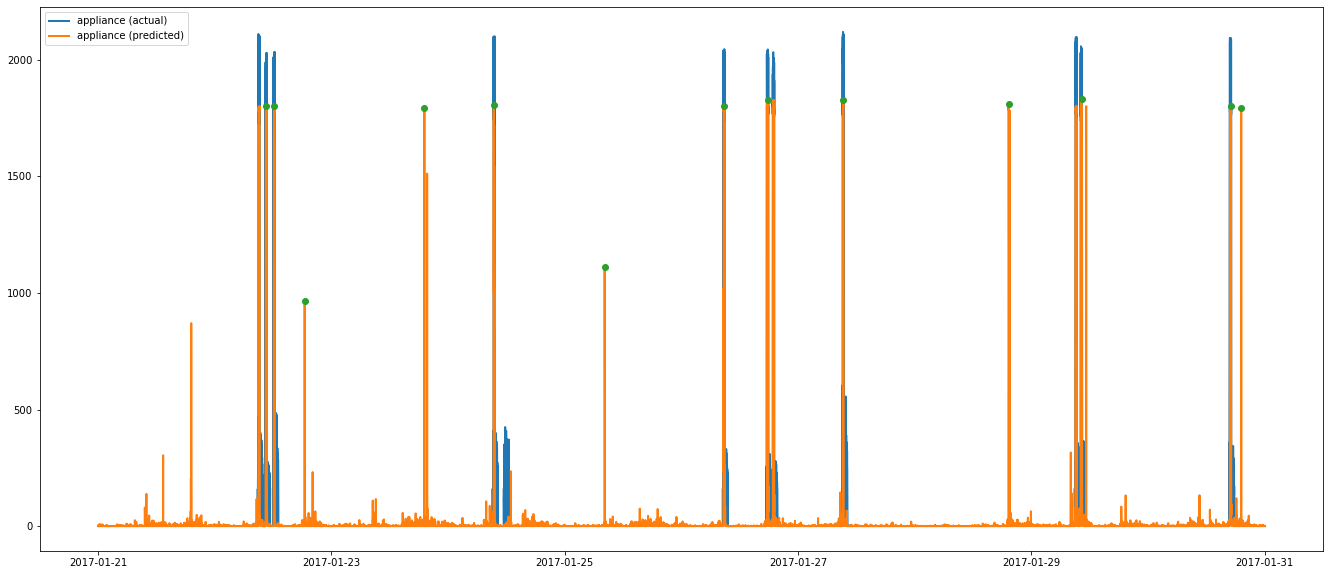

********************
[DRF-rice cooker]
********************


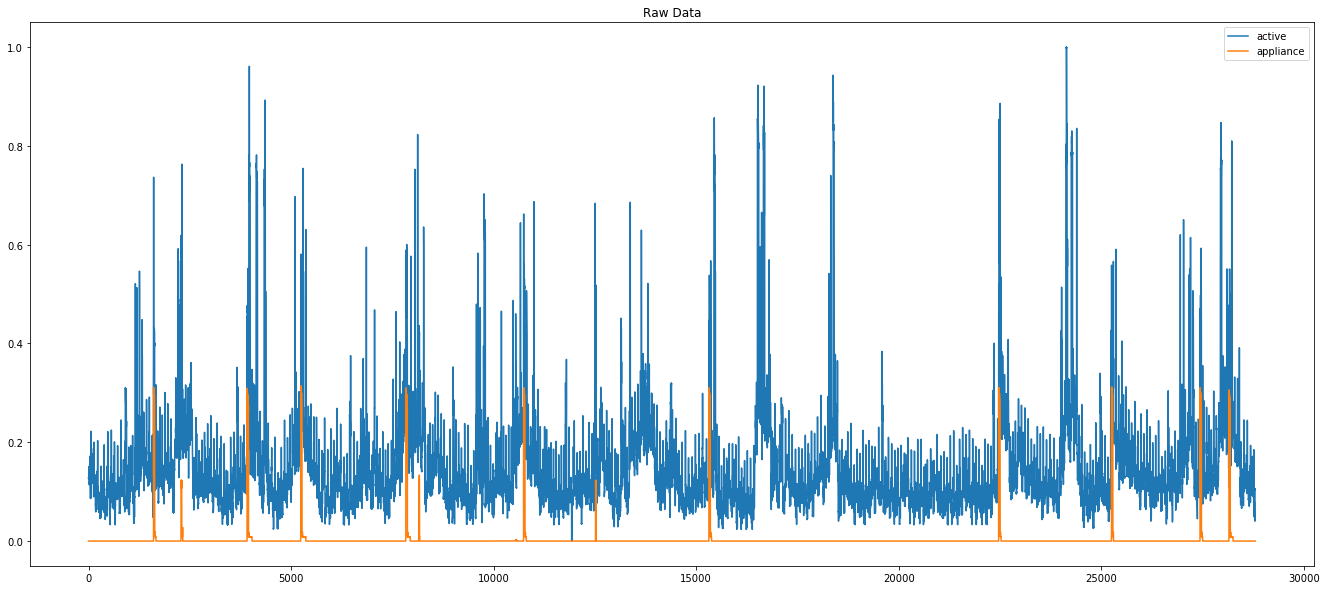

feature selection is done..
model fit is done..
a9      0.518820
q0      0.075795
min     0.057104
a8      0.048301
max     0.036519
diff    0.030259
a5      0.030181
a4      0.019031
f9      0.017361
f5      0.015297
f1      0.013687
a0      0.013218
a3      0.012326
a6      0.011937
q2      0.010840
a7      0.010186
std     0.009874
f8      0.009659
f2      0.009188
a1      0.007840
a2      0.007377
q1      0.007212
f4      0.006290
f6      0.005970
f3      0.005685
f7      0.004472
f0      0.003136
mean    0.002433
dtype: float64


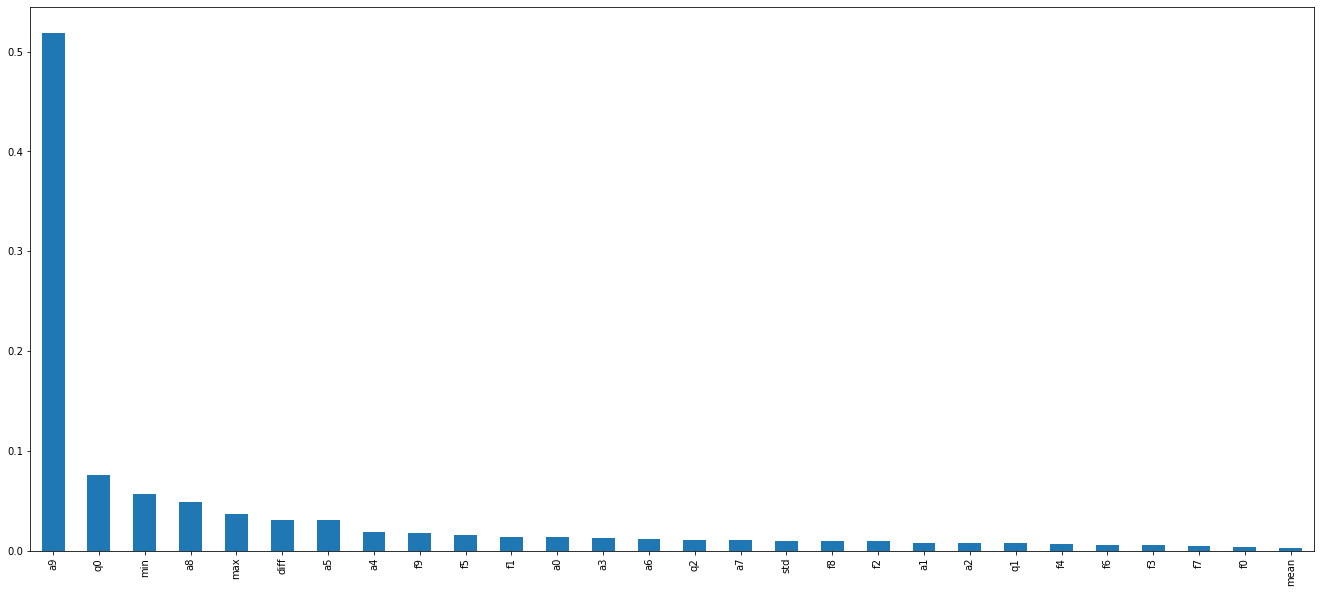

train on chunk is done..
elapsed time (secs) = 173.53020477294922
New sensible chunk: 11921
feature selection is done..
New sensible chunk: 5792
feature selection is done..
New sensible chunk: 11072
feature selection is done..
Disaggregation is done..
============ Recall: 0.9396825396825397
============ Precision: 0.6794185156847743
============ Accuracy: 0.9834641839783228
============ F1 Score: 0.7886323268206039
============ Relative error in total energy: 0.0032749745966202427
============ Mean absolute error(in Watts): 2.0377536366836666
<class 'pandas.core.series.Series'>
activations : [ 1626  3935  5253  7848  8168 10753 15318 22475 25249 27436 28147]
[2309 1318 2595  320 2585 4565 7157 2774 2187  711]


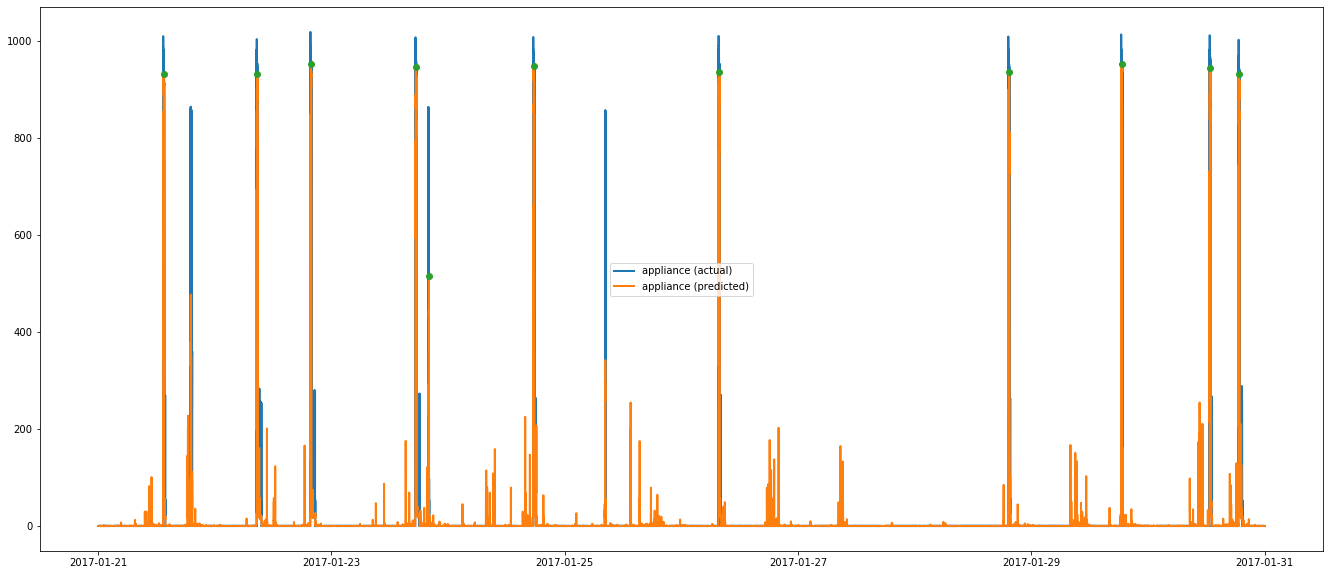

********************
[DRF-microwave]
********************


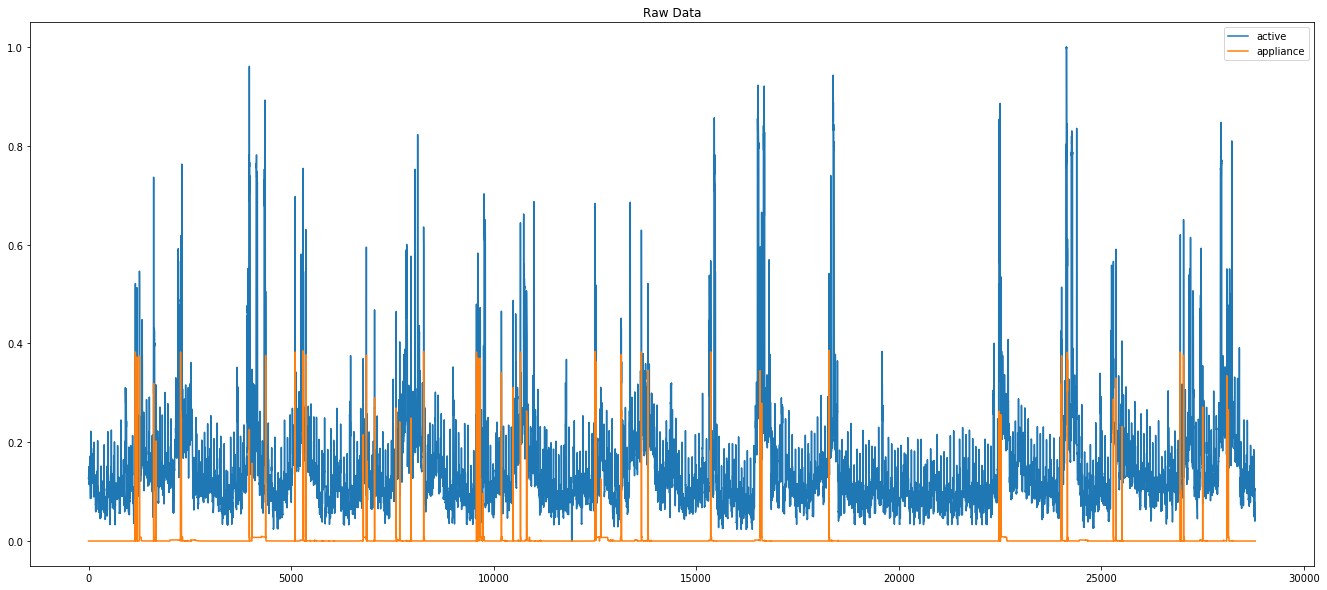

feature selection is done..
model fit is done..
a9      0.123173
diff    0.100490
f6      0.094207
f4      0.075420
f9      0.044555
f5      0.044332
max     0.042986
f1      0.042711
std     0.038241
a1      0.031756
a8      0.030061
a7      0.026727
f3      0.024783
a6      0.024250
a5      0.024034
a4      0.024017
q1      0.023582
f7      0.023405
min     0.022778
a0      0.021736
f8      0.021426
f2      0.019217
q0      0.016165
q2      0.015202
a2      0.015142
a3      0.013291
mean    0.008416
f0      0.007897
dtype: float64


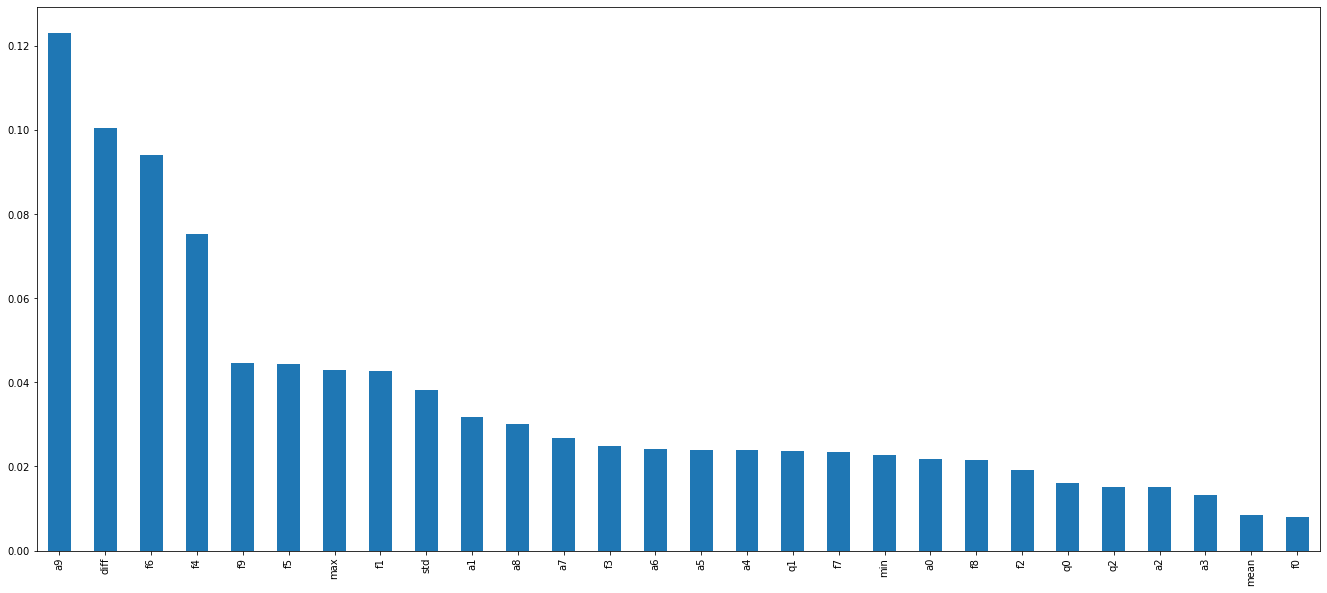

train on chunk is done..
elapsed time (secs) = 171.4989104270935
New sensible chunk: 11921
feature selection is done..
New sensible chunk: 5792
feature selection is done..
New sensible chunk: 11072
feature selection is done..
Disaggregation is done..
============ Recall: 0.9675405742821473
============ Precision: 0.7339015151515151
============ Accuracy: 0.978670186896408
============ F1 Score: 0.8346795907377491
============ Relative error in total energy: 0.015475923712221663
============ Mean absolute error(in Watts): 2.994612772410061
<class 'pandas.core.series.Series'>
activations : [ 1257  1607  2272  4371  5100  5364  6858  7060  7957  8272  9575 10191
 10661 12489 13133 13632 15343 16565 18262 22459 24144 25345 27013 28081]
[ 350  665 2099  729  264 1494  202  897  315 1303  616  470 1828  644
  499 1711 1222 1697 4197 1685 1201 1668 1068]


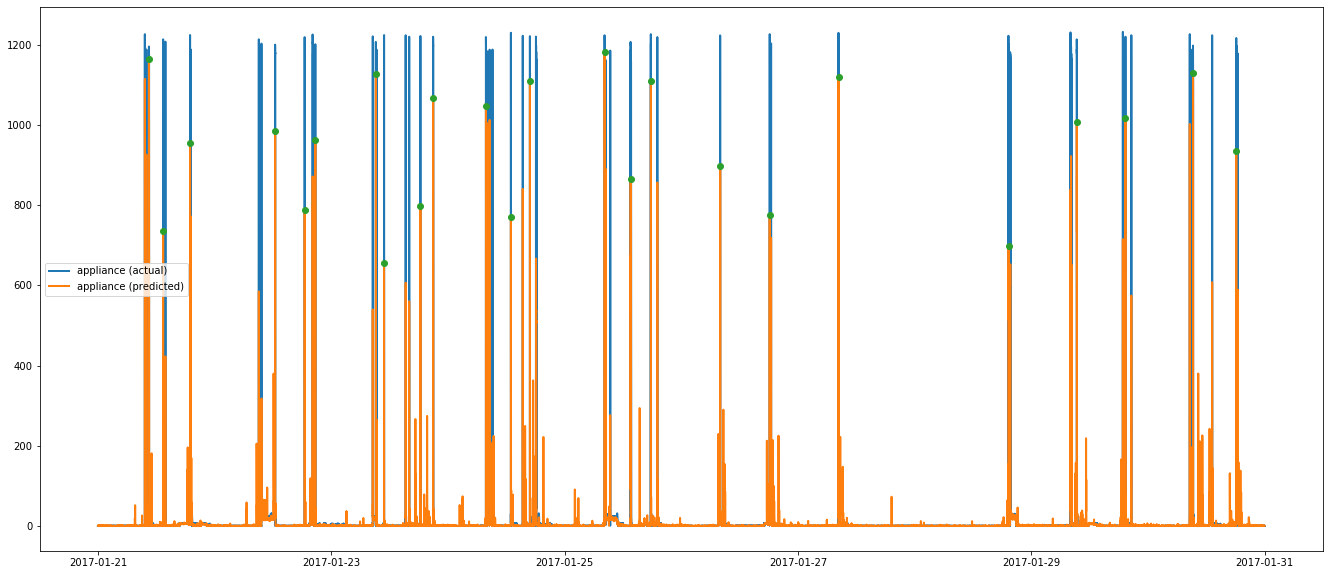

In [12]:
# 30 sec
TRAIN_SAMPLE_PERIOD = 30
TEST_SAMPLE_PERIOD = 30

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]    
   
    models = {}
   
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))
            
            num_of_activations = disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
    

### Sampling Period : 1 minute

********************
[DRF-washing machine]
********************


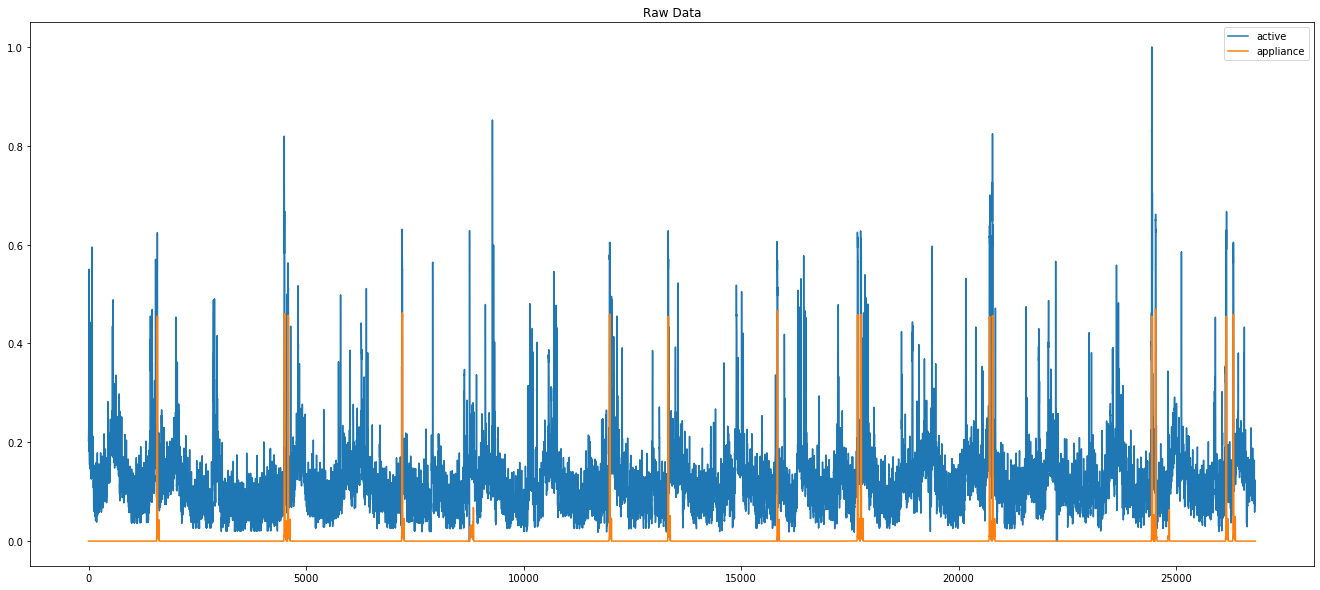

feature selection is done..
model fit is done..
a9      0.850119
a8      0.037105
q2      0.020551
min     0.018675
diff    0.009735
max     0.009163
a7      0.005981
a0      0.005466
a2      0.004652
f0      0.003357
a5      0.002966
mean    0.002805
f4      0.002678
a6      0.002585
a4      0.002554
f6      0.002502
f5      0.002272
f3      0.002194
std     0.002089
a1      0.001881
q0      0.001816
a3      0.001692
f1      0.001642
f7      0.001533
f9      0.001170
q1      0.001166
f8      0.000921
f2      0.000730
dtype: float64


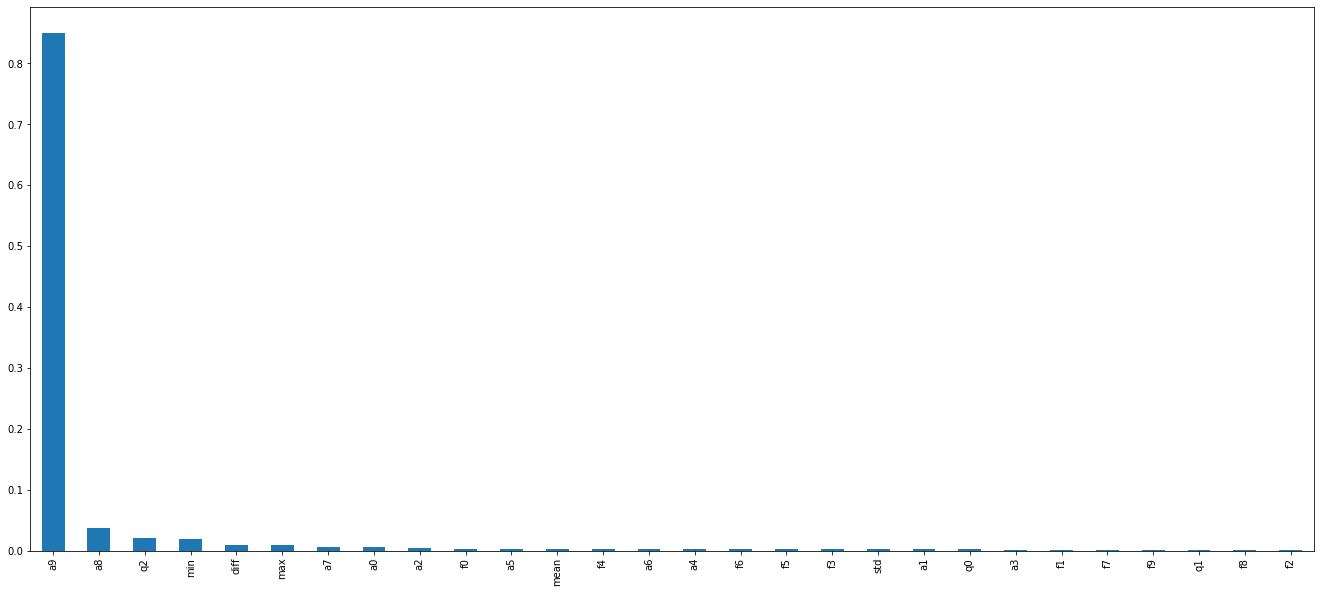

train on chunk is done..
elapsed time (secs) = 189.41025853157043
New sensible chunk: 5961
feature selection is done..
New sensible chunk: 2897
feature selection is done..
New sensible chunk: 5537
feature selection is done..
Disaggregation is done..
============ Recall: 0.40884718498659517
============ Precision: 0.3802992518703242
============ Accuracy: 0.9348339585938585
============ F1 Score: 0.39405684754521964
============ Relative error in total energy: 0.016869530312342847
============ Mean absolute error(in Watts): 7.899549408992479
<class 'pandas.core.series.Series'>
activations : [ 1151  2076  4891  7720  8330  9186 11233 12130 13976]
[ 925 2815 2829  610  856 2047  897 1846]


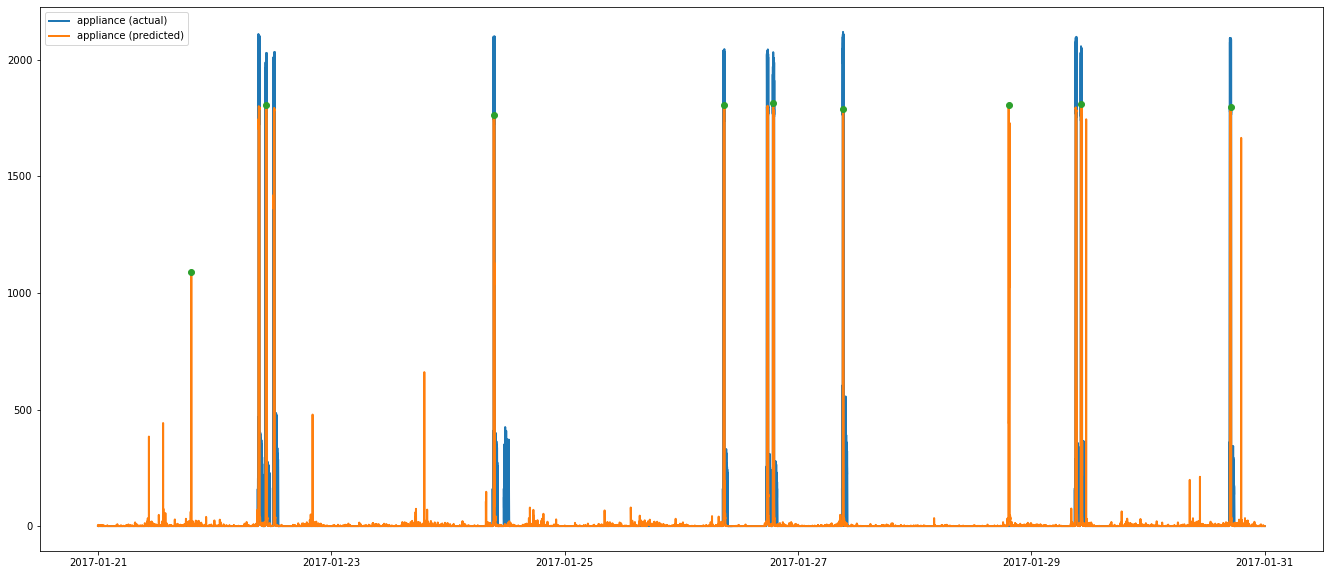

********************
[DRF-rice cooker]
********************


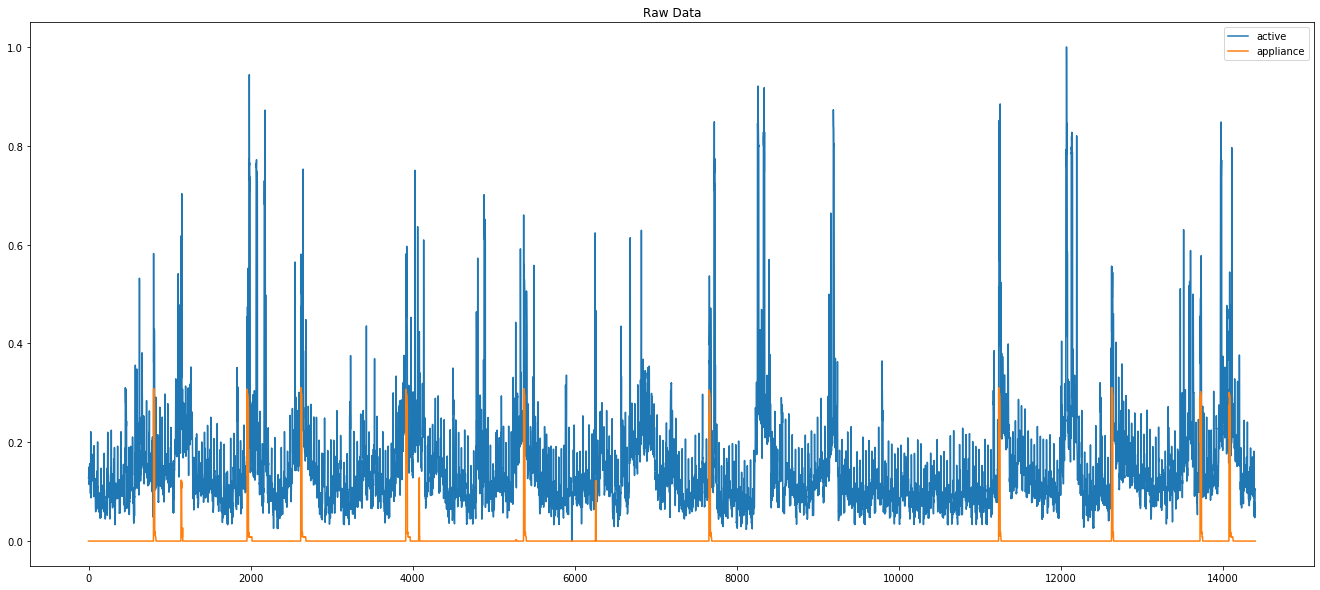

feature selection is done..
model fit is done..
a9      0.477538
a6      0.115295
max     0.100747
a7      0.054818
a8      0.031633
f5      0.028889
diff    0.020541
f2      0.013844
q2      0.013258
f8      0.012995
std     0.011910
f3      0.010826
a5      0.010187
f7      0.009326
a4      0.008635
f4      0.008445
a2      0.008385
f6      0.007235
min     0.007129
q1      0.006841
a3      0.006567
a0      0.006178
f9      0.006121
f1      0.005568
a1      0.004897
f0      0.004529
mean    0.004041
q0      0.003622
dtype: float64


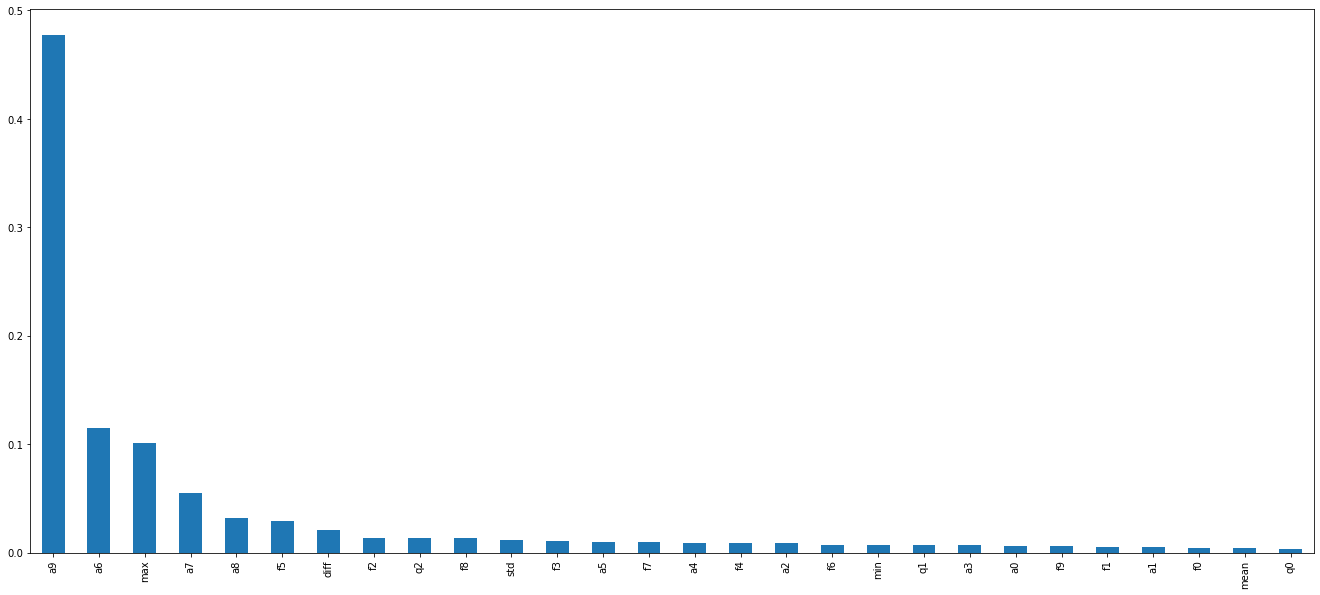

train on chunk is done..
elapsed time (secs) = 97.17407751083374
New sensible chunk: 5961
feature selection is done..
New sensible chunk: 2897
feature selection is done..
New sensible chunk: 5537
feature selection is done..
Disaggregation is done..
============ Recall: 0.9447983014861996
============ Precision: 0.6180555555555556
============ Accuracy: 0.9790885091010143
============ F1 Score: 0.7472712006717044
============ Relative error in total energy: 0.010919743451202802
============ Mean absolute error(in Watts): 2.5381624548951653
<class 'pandas.core.series.Series'>
activations : [  811  1146  1969  2625  3920  5377  7656 11238 12626 13718 14077]
[ 335  823  656 1295 1457 2279 3582 1388 1092  359]


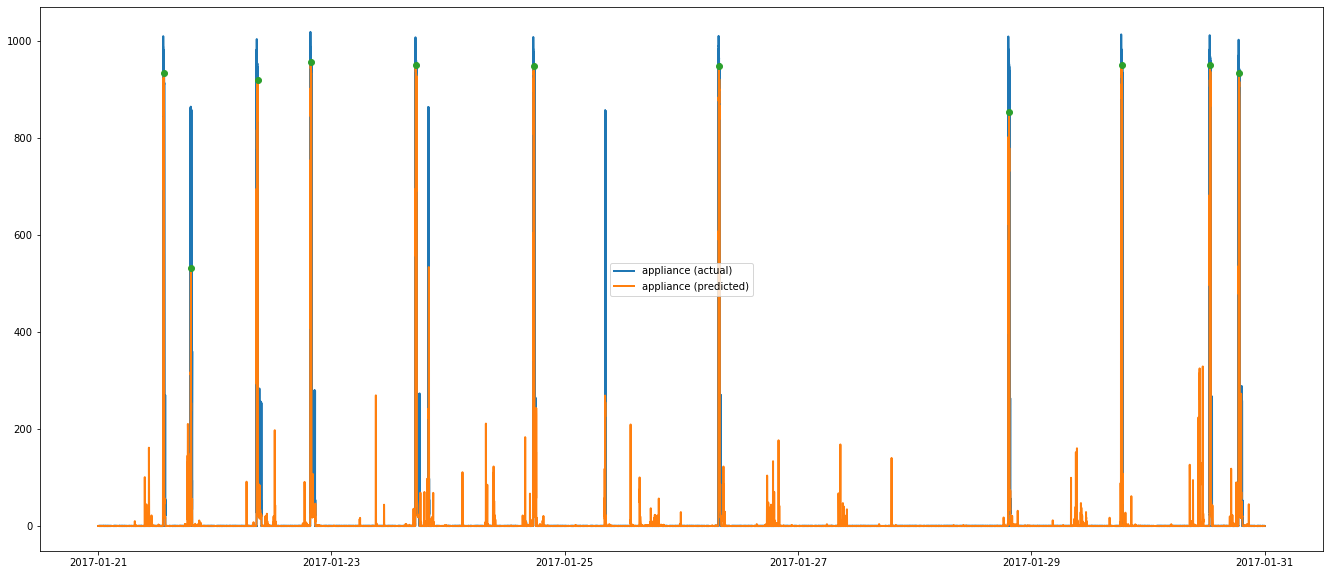

********************
[DRF-microwave]
********************


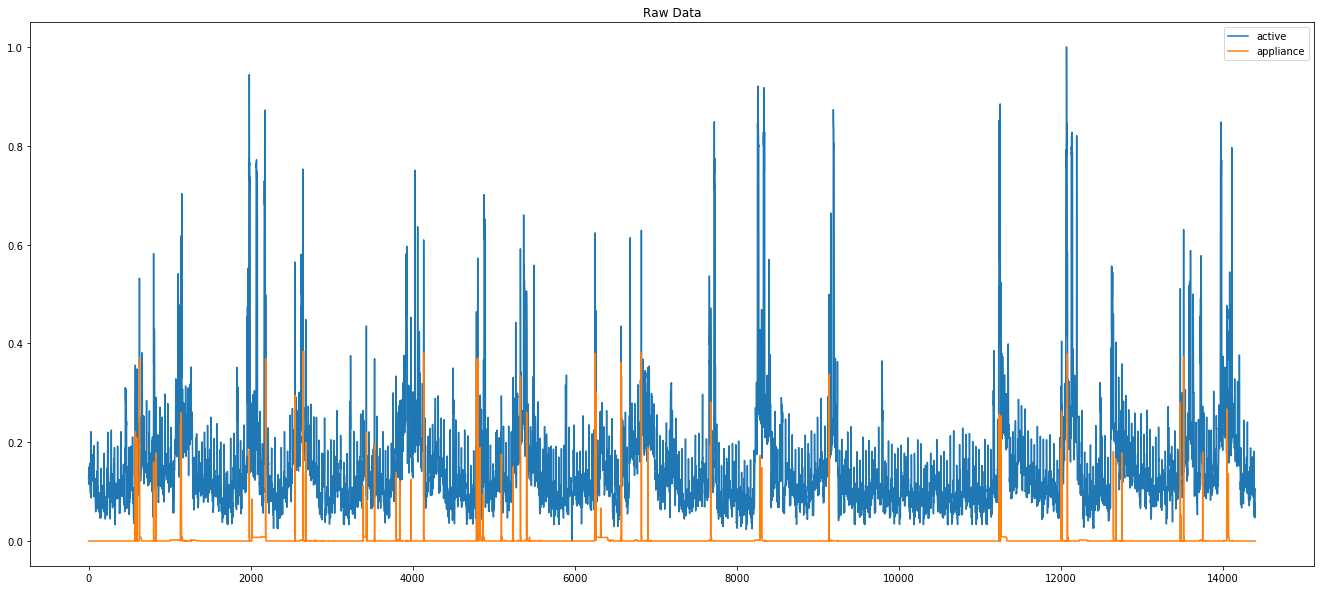

feature selection is done..
model fit is done..
a9      0.172858
a7      0.123725
diff    0.068656
f5      0.044027
a8      0.042832
f4      0.036738
a6      0.034582
f6      0.033194
q2      0.032309
std     0.028187
f1      0.028166
f8      0.027610
max     0.026287
a3      0.025374
f9      0.024494
q0      0.024343
a2      0.023652
f2      0.023586
a0      0.023544
f7      0.022985
f3      0.022259
a1      0.022020
a4      0.021124
min     0.018885
a5      0.017418
q1      0.013823
mean    0.010630
f0      0.006689
dtype: float64


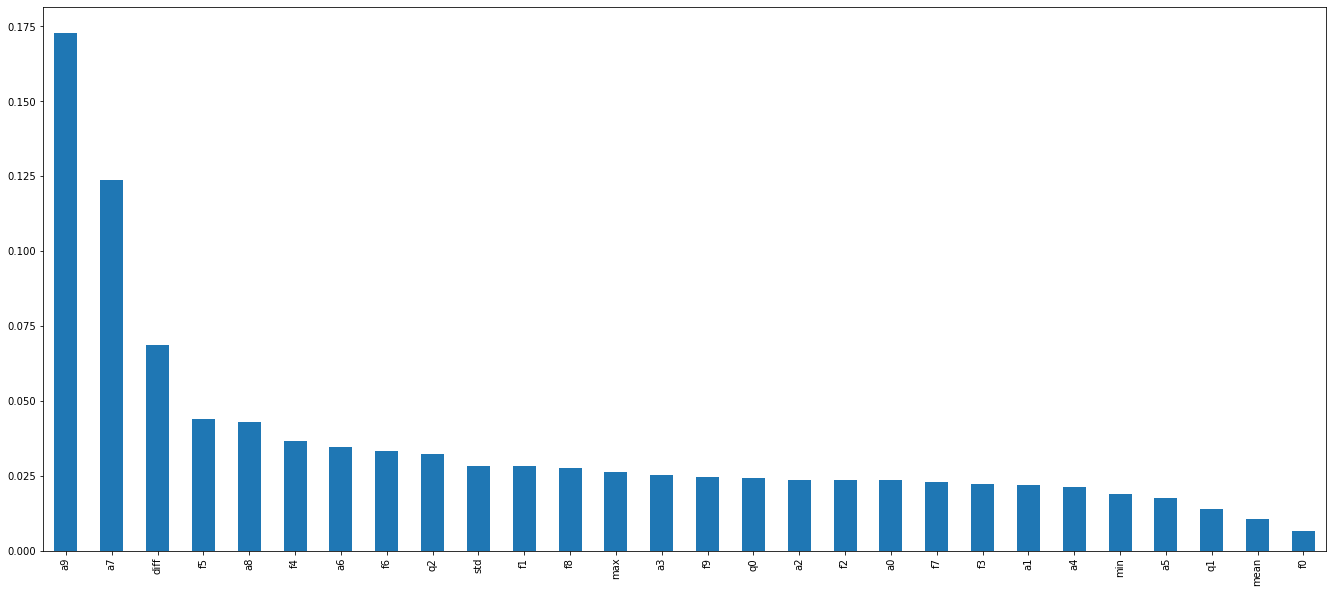

train on chunk is done..
elapsed time (secs) = 88.33705401420593
New sensible chunk: 5961
feature selection is done..
New sensible chunk: 2897
feature selection is done..
New sensible chunk: 5537
feature selection is done..
Disaggregation is done..
============ Recall: 0.9779951100244498
============ Precision: 0.6700167504187605
============ Accuracy: 0.9713769626233153
============ F1 Score: 0.7952286282306164
============ Relative error in total energy: 0.024241106470000984
============ Mean absolute error(in Watts): 3.286565087792942
<class 'pandas.core.series.Series'>
activations : [  628  1142  2186  2550  4136  4788  5330  6246  6567  6817  7672  9133
 11252 12074 13468]
[ 514 1044  364 1586  652  542  916  321  250  855 1461 2119  822 1394]


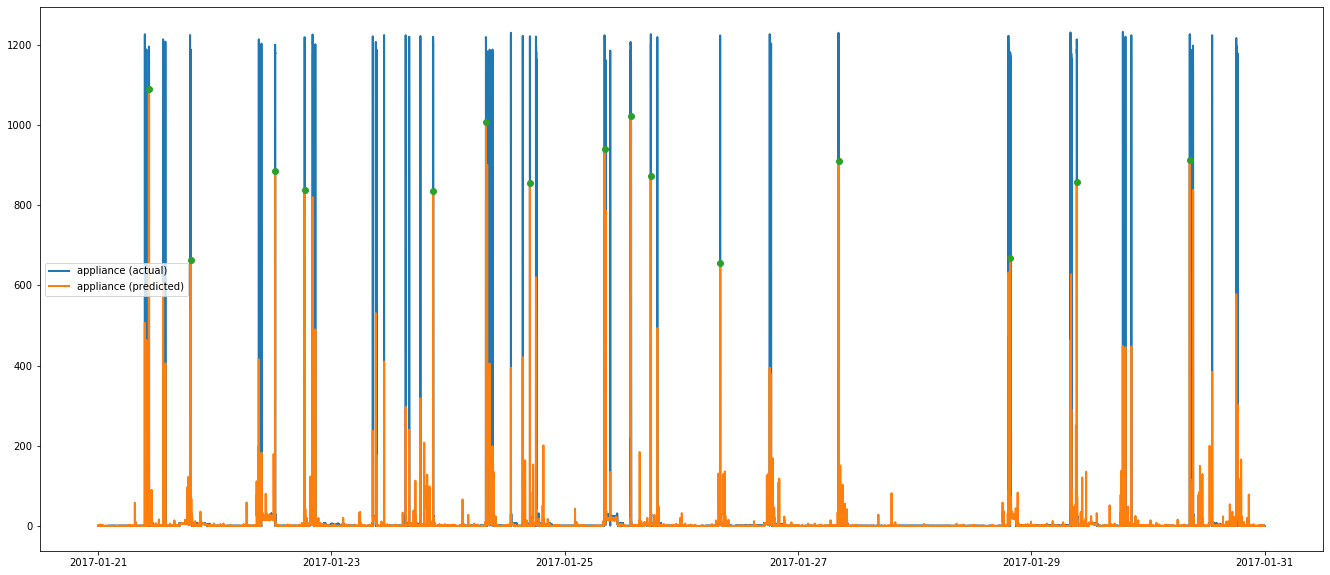

In [9]:
# 1m
TRAIN_SAMPLE_PERIOD = 60
TEST_SAMPLE_PERIOD = 60

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]    
   
    models = {}
   
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))
            
            num_of_activations = disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)
    

### Sampling Period : 15 minute

********************
[DRF-washing machine]
********************


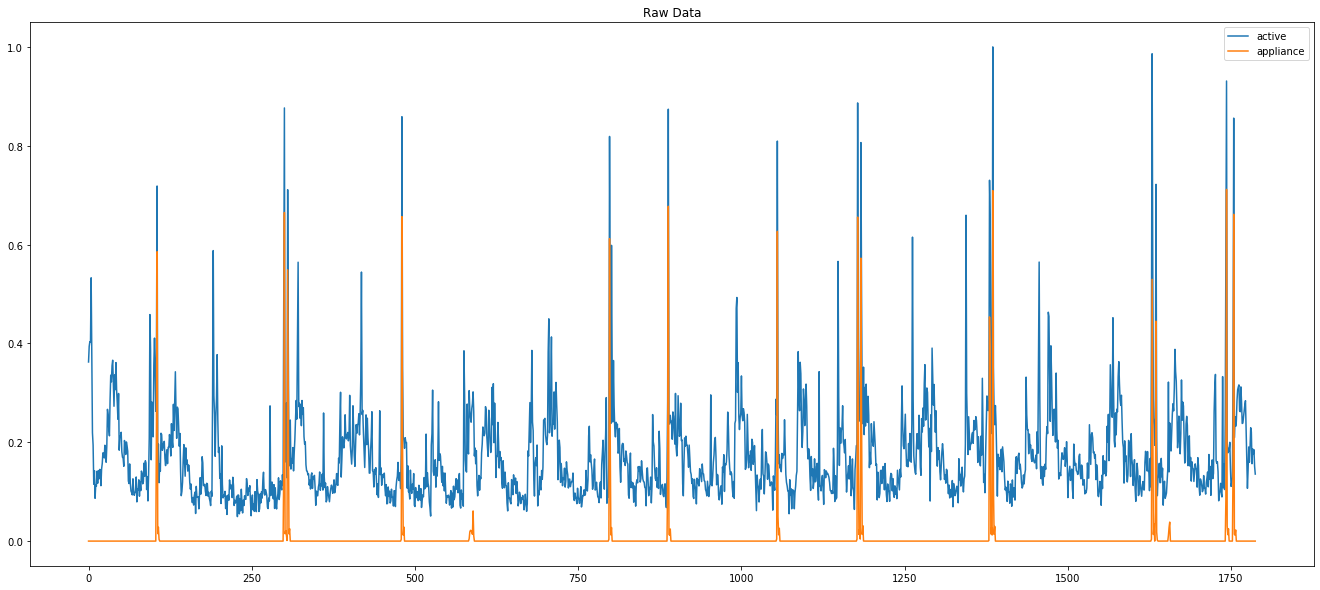

feature selection is done..
model fit is done..
a9      0.908809
a8      0.044147
f5      0.006665
a6      0.005074
f6      0.003894
f4      0.003202
a7      0.003094
std     0.002580
max     0.002521
f8      0.001687
a0      0.001602
q1      0.001570
f3      0.001500
diff    0.001469
a3      0.001463
f2      0.001247
a1      0.001152
f7      0.001002
a4      0.000991
q0      0.000978
f9      0.000932
f0      0.000804
a2      0.000790
a5      0.000714
f1      0.000581
mean    0.000555
q2      0.000493
min     0.000485
dtype: float64


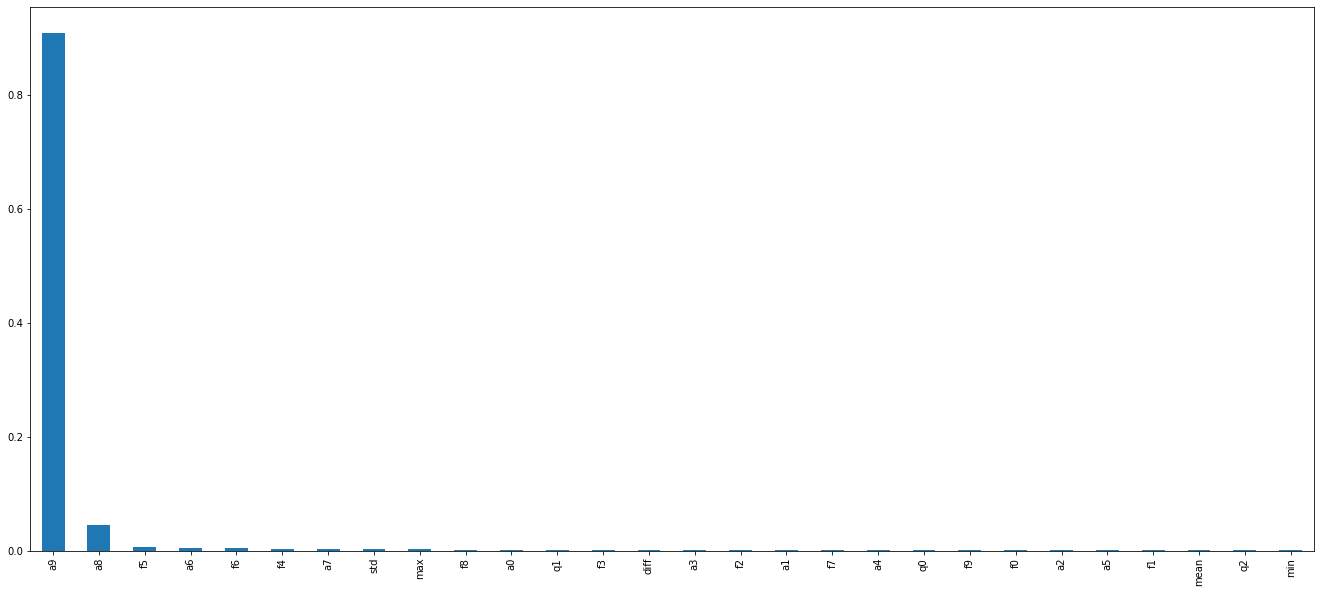

train on chunk is done..
elapsed time (secs) = 49.72745203971863
New sensible chunk: 398
feature selection is done..
New sensible chunk: 194
feature selection is done..
New sensible chunk: 371
feature selection is done..
Disaggregation is done..
============ Recall: 0.7678571428571429
============ Precision: 0.4574468085106383
============ Accuracy: 0.9334027055150884
============ F1 Score: 0.5733333333333334
============ Relative error in total energy: 0.05555228472672501
============ Mean absolute error(in Watts): 16.24210347032071
<class 'pandas.core.series.Series'>
activations : [132 551 751]
[419 200]


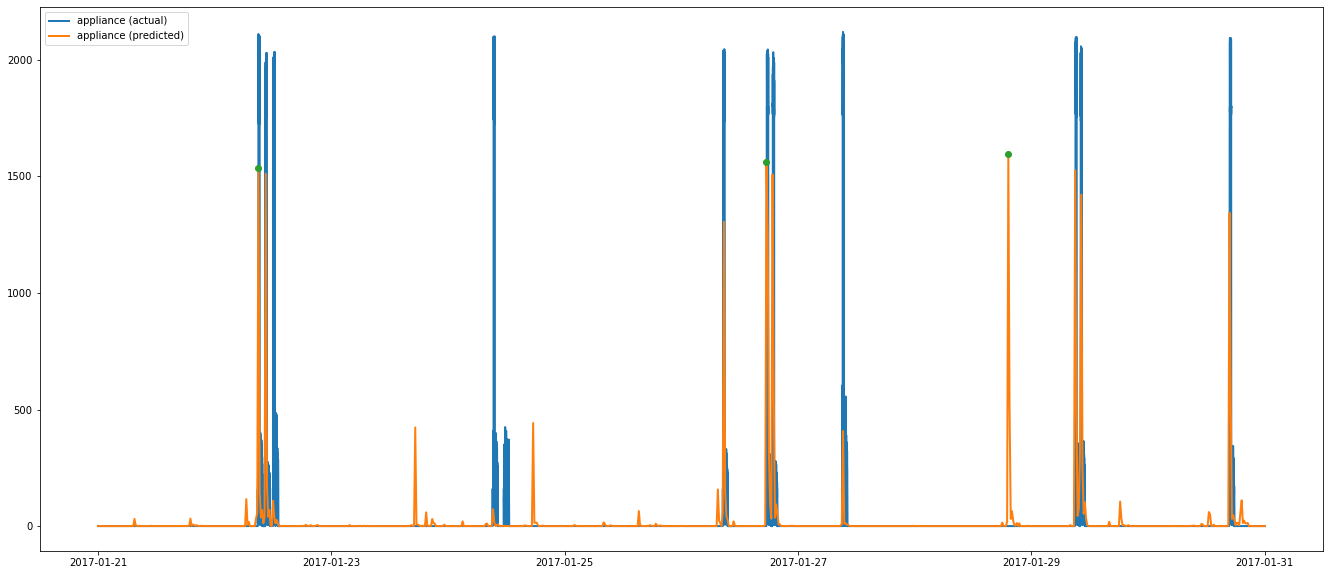

********************
[DRF-rice cooker]
********************


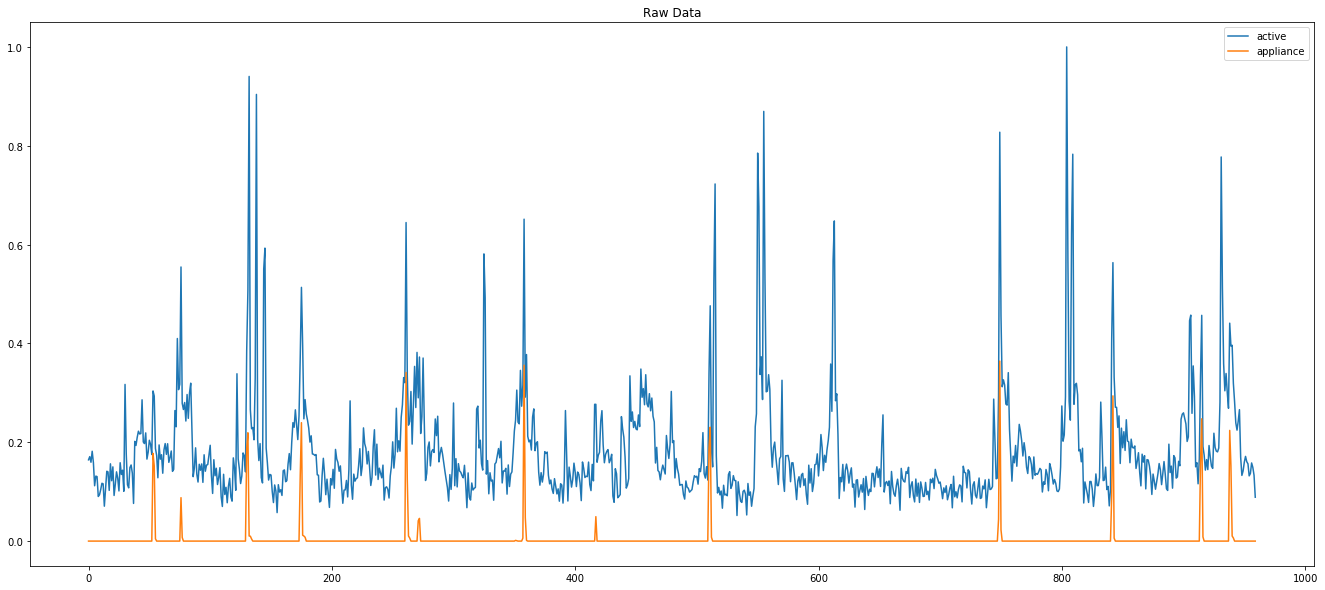

feature selection is done..
model fit is done..
a9      0.315842
a7      0.077678
std     0.071688
a8      0.052237
a6      0.049526
a1      0.035248
min     0.033444
diff    0.030263
a5      0.025683
max     0.025396
a0      0.024236
f7      0.020494
f0      0.018820
q2      0.017715
a3      0.017424
f8      0.017307
a4      0.017223
mean    0.016799
f1      0.016308
a2      0.015936
q1      0.015125
f5      0.014341
f4      0.014027
f2      0.013528
f3      0.012540
f9      0.011302
f6      0.010517
q0      0.009353
dtype: float64


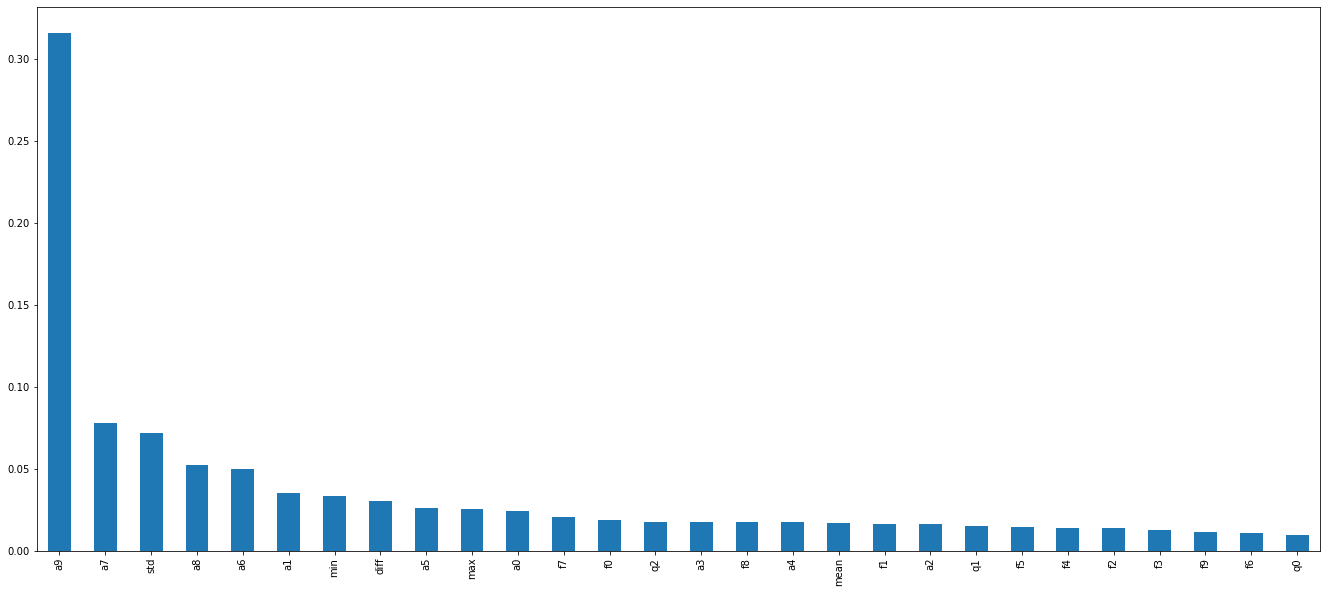

train on chunk is done..
elapsed time (secs) = 23.801605939865112
New sensible chunk: 398
feature selection is done..
New sensible chunk: 194
feature selection is done..
New sensible chunk: 371
feature selection is done..
Disaggregation is done..
============ Recall: 0.8837209302325582
============ Precision: 0.4418604651162791
============ Accuracy: 0.9448491155046826
============ F1 Score: 0.5891472868217054
============ Relative error in total energy: 0.0521345608316656
============ Mean absolute error(in Watts): 6.772387265100628
<class 'pandas.core.series.Series'>
activations : [261 512 751]
[251 239]


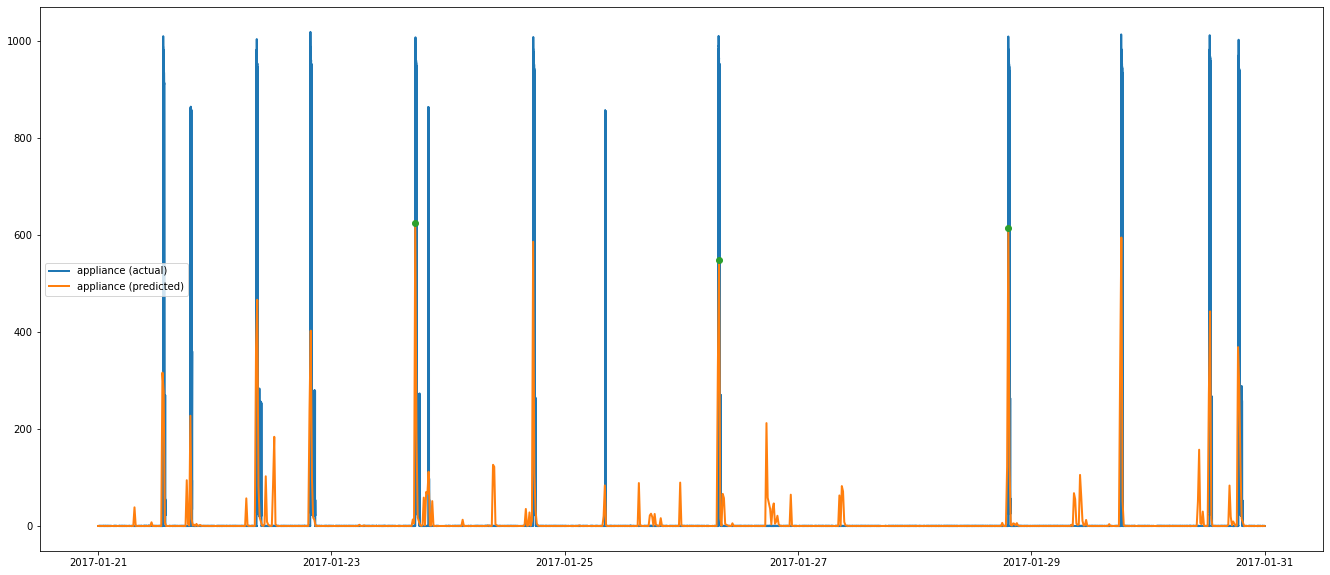

********************
[DRF-microwave]
********************


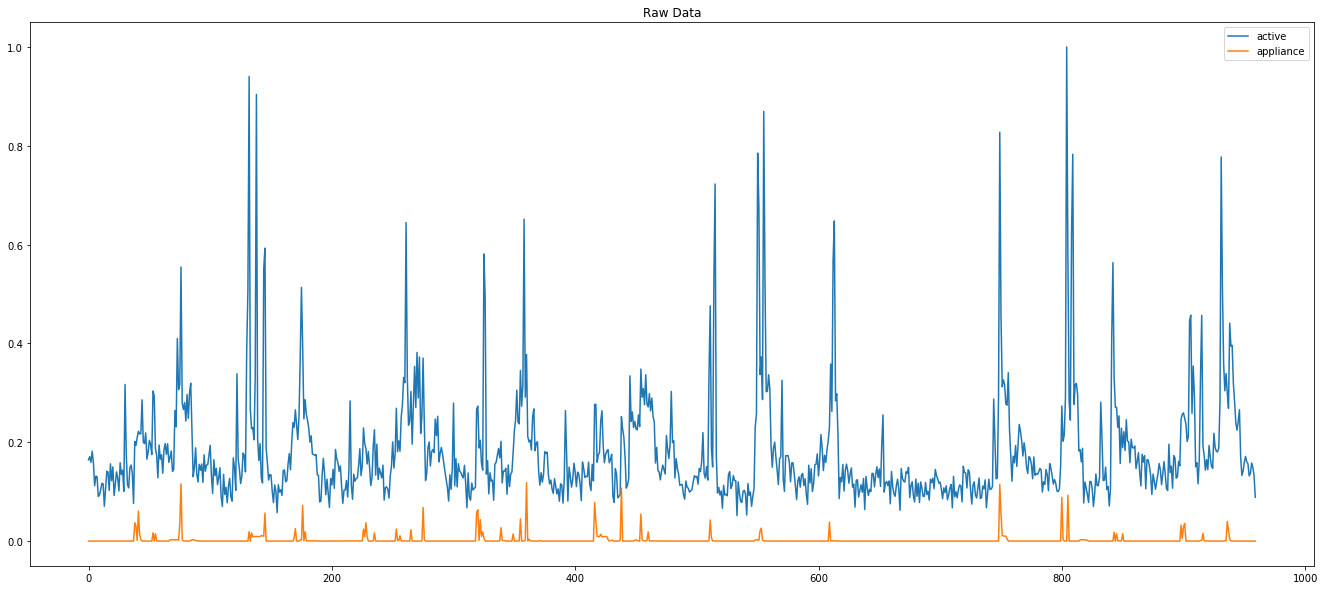

feature selection is done..
model fit is done..
a9      0.192552
a8      0.081695
a6      0.079997
a7      0.074333
max     0.046635
a4      0.043049
diff    0.042370
q0      0.038672
min     0.036115
a5      0.030403
a2      0.028129
f5      0.027769
a3      0.023750
std     0.023019
a1      0.022957
a0      0.021195
f6      0.019950
f4      0.019836
f7      0.019582
q1      0.018653
f9      0.018141
f8      0.017147
f2      0.015748
f1      0.015572
q2      0.011709
mean    0.010579
f0      0.010383
f3      0.010060
dtype: float64


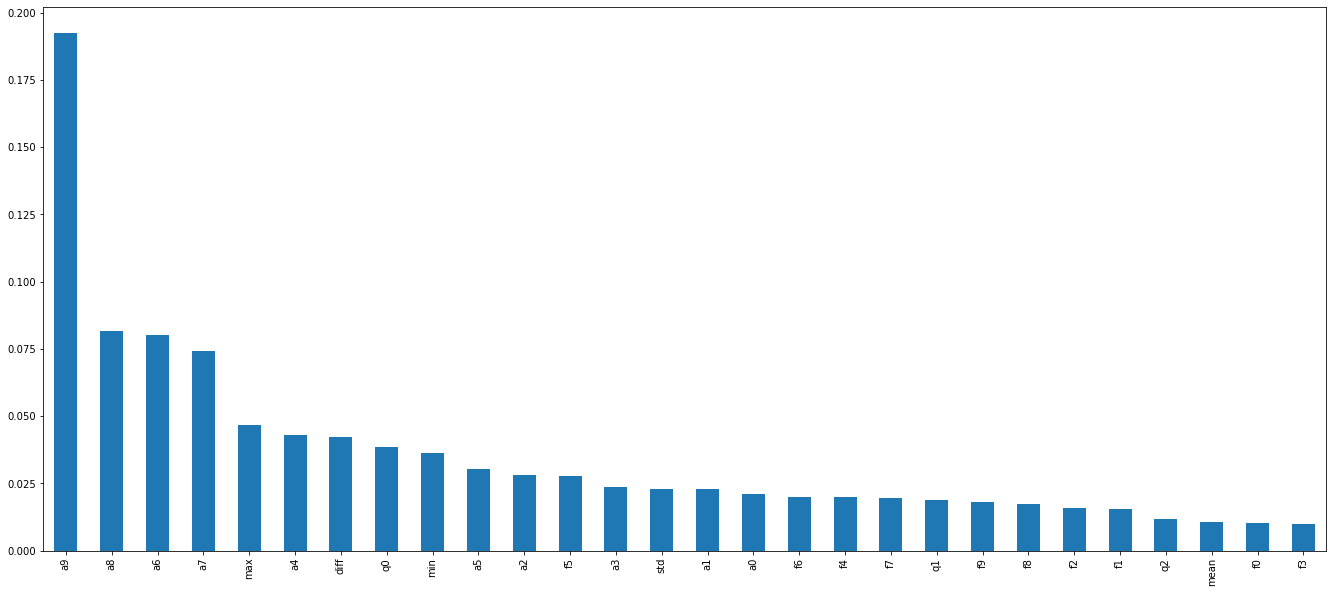

train on chunk is done..
elapsed time (secs) = 23.548566818237305
New sensible chunk: 398
feature selection is done..
New sensible chunk: 194
feature selection is done..
New sensible chunk: 371
feature selection is done..
Disaggregation is done..
============ Recall: 0.9761904761904762
============ Precision: 0.5394736842105263
============ Accuracy: 0.9250780437044746
============ F1 Score: 0.6949152542372882
============ Relative error in total energy: 0.04542009725757466
============ Mean absolute error(in Watts): 3.854933090166614
<class 'pandas.core.series.Series'>
activations : [ 76 360 751]
[284 391]


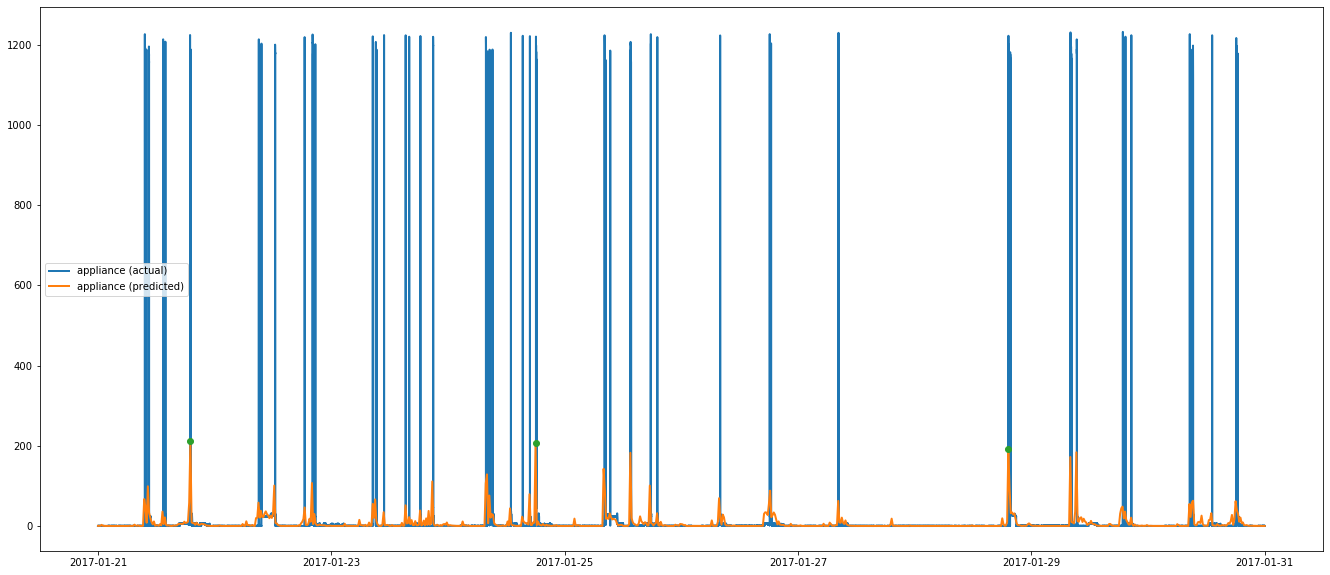

In [10]:
# 15m
TRAIN_SAMPLE_PERIOD = 900
TEST_SAMPLE_PERIOD = 900

T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]    
   
    models = {}
   
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))
            
            num_of_activations = disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)

### use reactive

********************
[DRF-washing machine]
********************
elapsed time (secs) = 64.94419574737549
train & test error 'RandomForestRegressor' object has no attribute 'estimators_'
********************
[DRF-rice cooker]
********************


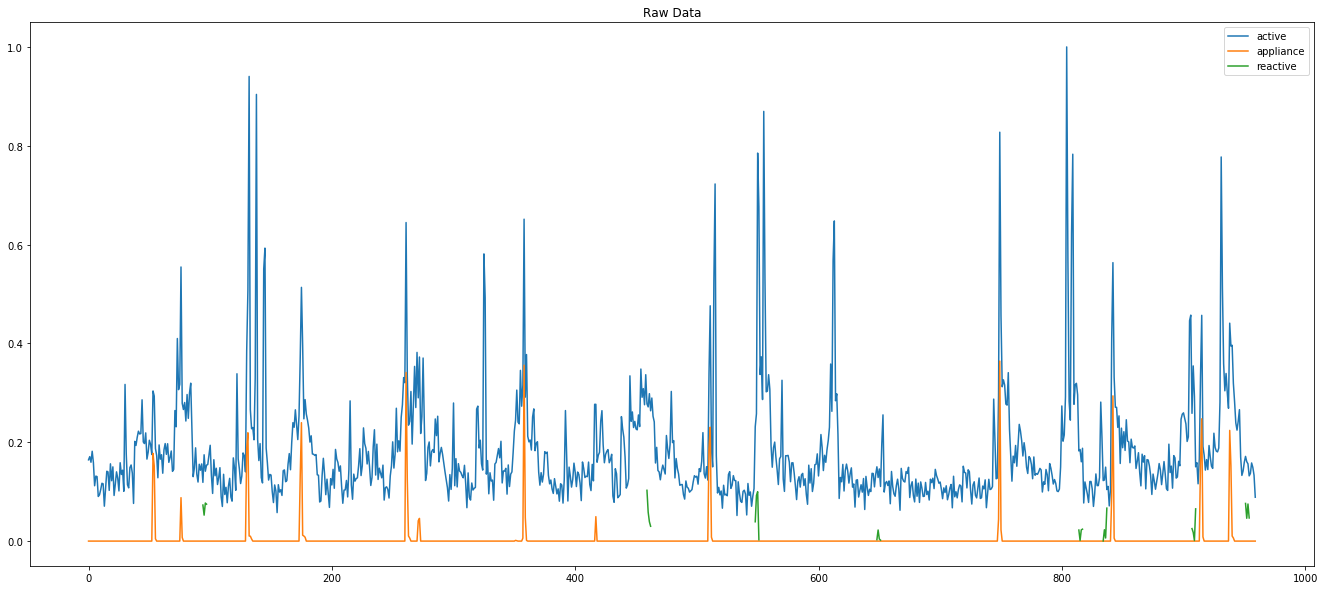

feature selection is done..
model fit is done..
ap9     1.500890e-01
a9      1.390744e-01
std     7.620448e-02
a7      3.876215e-02
max     3.590025e-02
ap7     3.427556e-02
q2      3.286235e-02
ap6     2.935041e-02
f3      2.686899e-02
a6      2.389753e-02
a8      2.339078e-02
r3      2.316463e-02
min     2.283276e-02
f1      2.159304e-02
ap3     2.079115e-02
ap8     1.836182e-02
f4      1.783089e-02
diff    1.759433e-02
a3      1.730978e-02
a1      1.678999e-02
f5      1.594707e-02
f0      1.549612e-02
f8      1.379483e-02
f6      1.376806e-02
ap1     1.361342e-02
f7      1.321015e-02
ap0     1.136030e-02
mean    1.125266e-02
pf4     1.086528e-02
q0      1.017638e-02
f9      9.743390e-03
a5      9.427445e-03
ap5     9.255125e-03
a2      7.965601e-03
a0      7.747536e-03
a4      5.814815e-03
f2      5.390835e-03
ap2     5.084499e-03
q1      4.119972e-03
ap4     4.052403e-03
pf5     3.208866e-03
r2      3.106057e-03
r4      2.878708e-03
r5      2.161397e-03
pf3     1.718987e-03
r7     

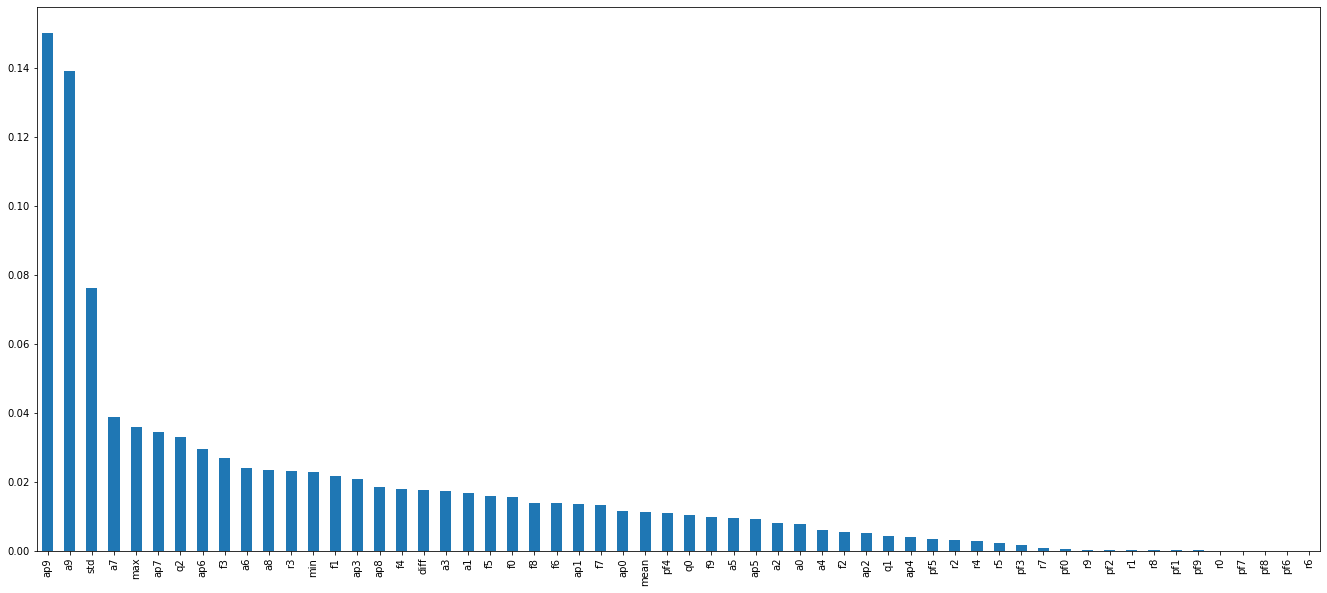

train on chunk is done..
elapsed time (secs) = 33.92921757698059
New sensible chunk: 398
feature selection is done..
New sensible chunk: 194
feature selection is done..
New sensible chunk: 371
feature selection is done..
Disaggregation is done..
============ Recall: 0.9285714285714286
============ Precision: 0.3644859813084112
============ Accuracy: 0.9261186264308012
============ F1 Score: 0.5234899328859061
============ Relative error in total energy: 0.06807088401081607
============ Mean absolute error(in Watts): 6.988794515184954
activations : [ 55  77 132 176 263 327 360 419 459 514 555 616 753 810 845 918 942]


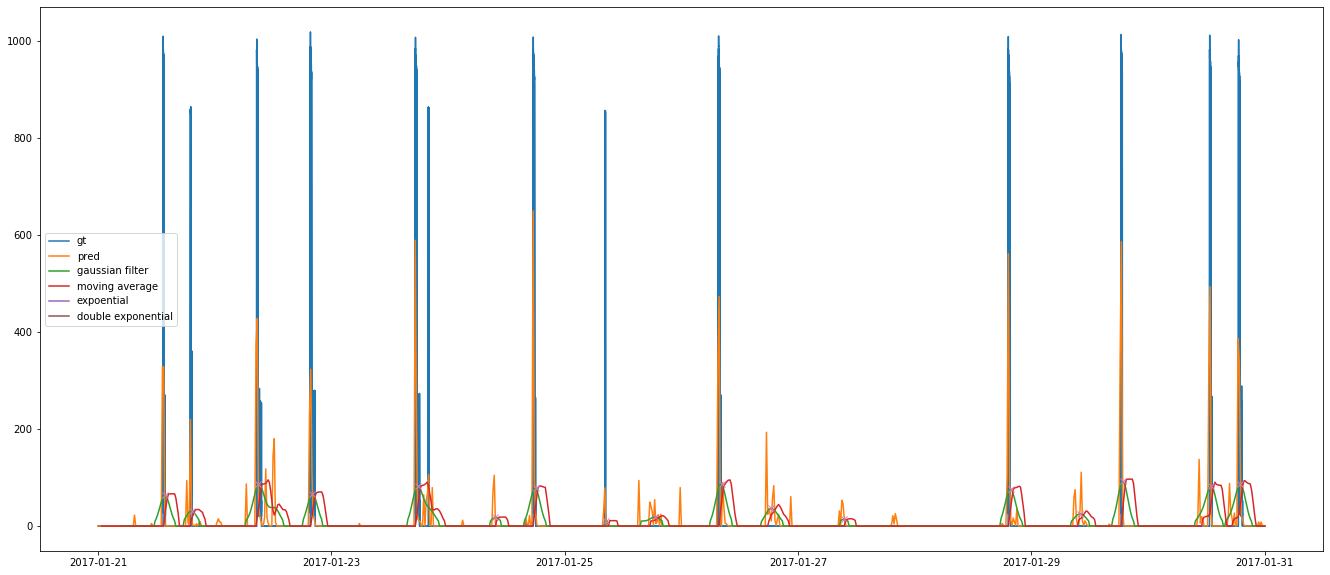

********************
[DRF-microwave]
********************


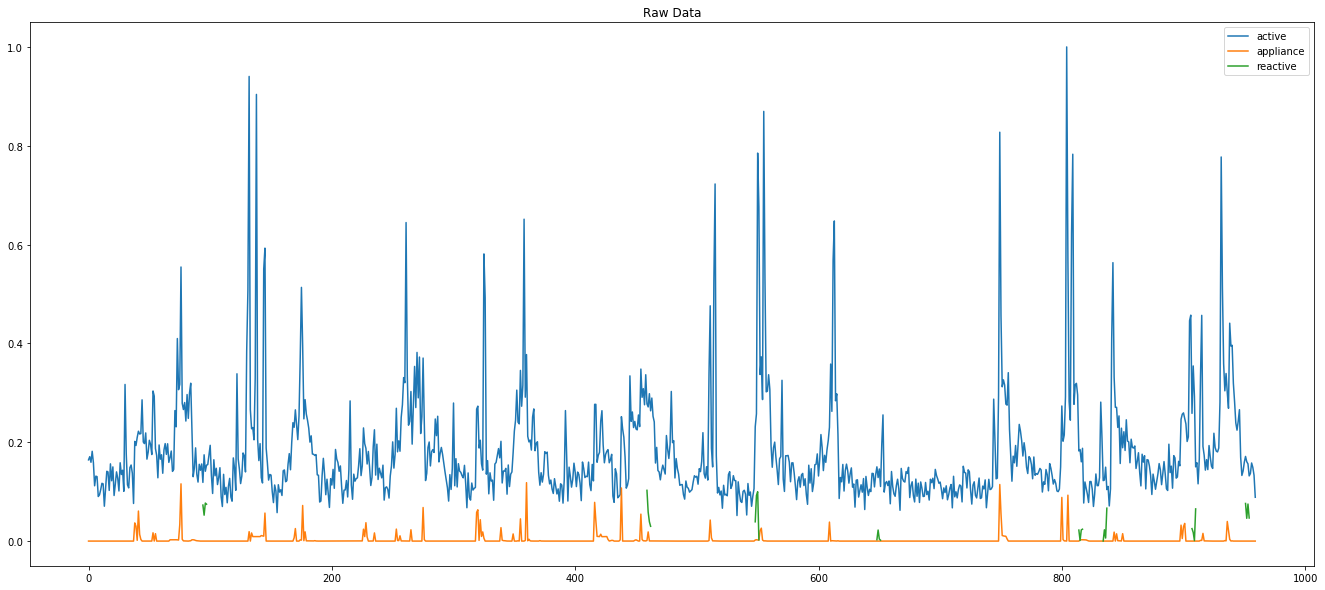

feature selection is done..
model fit is done..
a9      0.106781
ap9     0.084953
a6      0.049225
ap6     0.047110
max     0.044564
min     0.033558
ap8     0.033088
a7      0.031783
f5      0.031680
a8      0.030545
ap7     0.029258
std     0.028251
q0      0.026763
diff    0.025252
f6      0.024512
ap4     0.023280
a4      0.022846
ap1     0.022246
f3      0.021895
a5      0.019391
f7      0.019260
f2      0.018888
f4      0.018106
a2      0.018069
a3      0.017845
a1      0.016488
ap5     0.015952
f1      0.015638
ap2     0.015547
f8      0.015477
a0      0.015448
ap3     0.012870
f9      0.012482
ap0     0.011895
q1      0.009960
q2      0.009396
mean    0.008569
f0      0.006476
r6      0.000718
r8      0.000691
pf1     0.000571
pf8     0.000465
r2      0.000392
pf9     0.000309
r0      0.000294
r9      0.000180
pf4     0.000162
r3      0.000160
pf3     0.000134
pf0     0.000121
pf2     0.000114
pf7     0.000102
r1      0.000077
r4      0.000064
pf5     0.000060
r5      0.000015


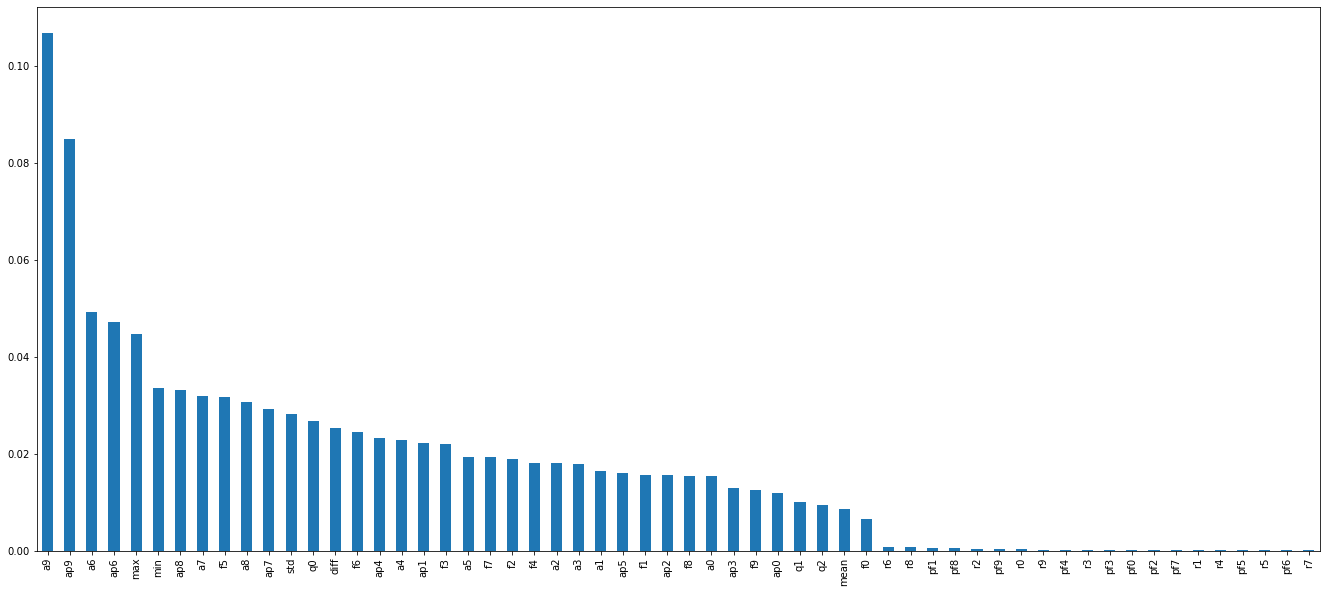

train on chunk is done..
elapsed time (secs) = 34.20819067955017
New sensible chunk: 398
feature selection is done..
New sensible chunk: 194
feature selection is done..
New sensible chunk: 371
feature selection is done..
Disaggregation is done..
============ Recall: 0.9647058823529412
============ Precision: 0.5394736842105263
============ Accuracy: 0.9240374609781478
============ F1 Score: 0.6919831223628692
============ Relative error in total energy: 0.06564601823762065
============ Mean absolute error(in Watts): 3.9493377740480473
activations : [ 42  77 142 177 229 256 275 323 360 420 441 456 515 555 614 753 807 847
 904 940]


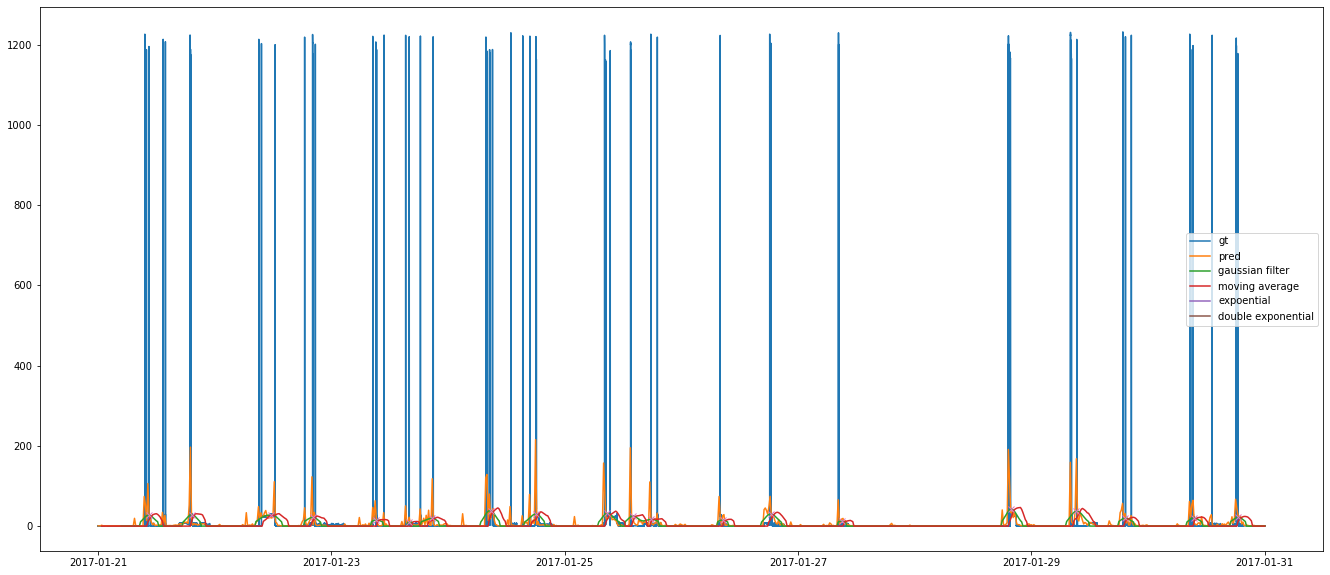

In [19]:
# 15m
TRAIN_SAMPLE_PERIOD = 900
TEST_SAMPLE_PERIOD = 900


T_S = '2017-01-01'
T_E = '2017-01-20'
P_S = '2017-01-21'
P_E = '2017-01-31'

dataset = DataSet(DATA_FILE)
dataset.set_window(start=T_S, end=T_E)

train_elec = dataset.buildings[HOME_ID].elec
train_mains = train_elec.all_meters()[0] # The aggregated meter that provides the input

for aname in appliances:
    
    train_meter = train_elec.submeters()[aname]    
   
    models = {}
   
    models['DRF-' + aname] = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=True)
    
    for mname, model in models.items():
        
        try:
            
            print("*"*20)
            print("[" + mname + "]") 
            print("*" *20)

            start = time.time()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
            end = time.time()            
            print("elapsed time (secs) = " + str(end-start))
            
            num_of_activations = disaggregate(dataset, model, aname, P_S, P_E, True)
        
        except Exception as e:
            print('train & test error', e)